# Proof of Concept: Linking Climate Data with CFD Prices for Agricultural Commodities

**Objective:** Evaluate the feasibility of predicting CFD price movements (e.g., cotton) by incorporating monthly (or daily aggregated) climatic data over the last 20 years. This notebook serves as a preliminary investigation using machine learning techniques and exploratory data analysis.

**Outline:**
1. Data Acquisition and Loading
2. Data Preprocessing and Aggregation
3. Exploratory Data Analysis (EDA)
4. Feature Engineering (including creation of climatic indices and lag variables)
5. Modeling: Training a simple ML model (e.g., RandomForest)
6. Model Evaluation and Interpretation
7. Conclusions and Next Steps


## 1. Importing Libraries
Import necessary libraries for data analysis, visualization, and modeling.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# You can add more libraries as needed

%matplotlib inline

## 2. Data Acquisition and Loading
Load the climate and CFD price data. For this PoC, you can use synthetic datasets or CSV samples.

*Example files:*
- `climate_data.csv`: Daily or monthly climate variables (temperature, precipitation, extreme events, etc.)
- `price_data.csv`: Historical CFD price series (e.g., cotton) on a monthly basis

In [4]:
import xarray as xr
ds=xr.open_dataset("/Users/charly_1/Downloads/22491997/CROPGRIDSv1.08_NC_maps/CROPGRIDSv1.08_cocoa.nc")

ValueError: No matching item found for the query 'naturalearth_lowres'.

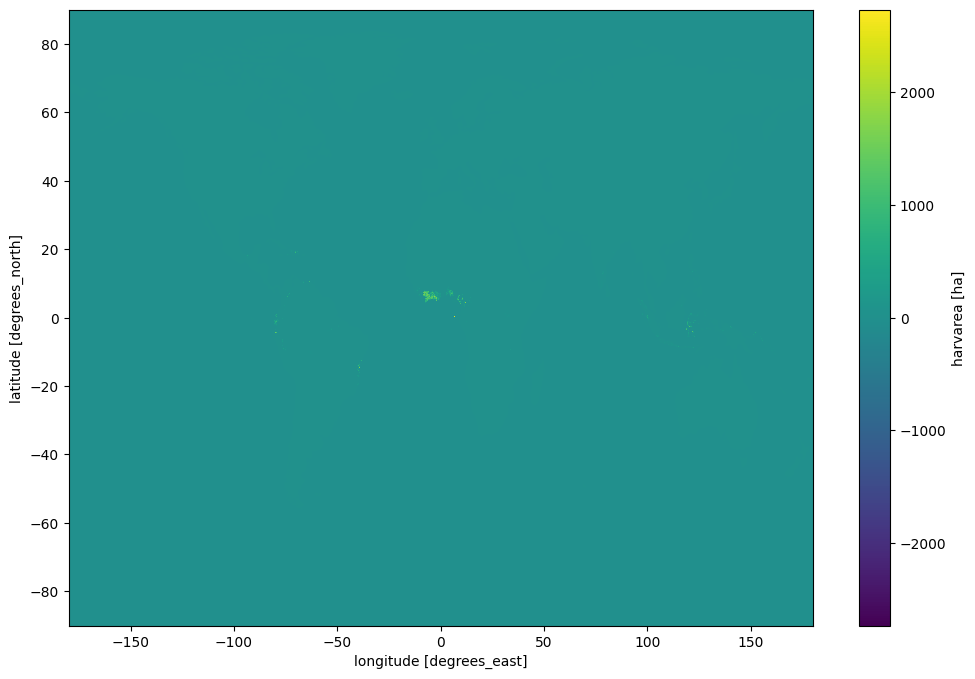

In [ ]:
import geopandas as gpd
from geodatasets import get_path

ax = ds["harvarea"].plot(figsize=(12, 8), cmap='viridis')
world = gpd.read_file(get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title("Harvarea overlayed on World Countries")
plt.show()


In [3]:
import requests
import geopandas as gpd
from pathlib import Path

# URL del GeoJSON de límites administrativos
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/geojson?lang=en&timezone=Europe%2FBerlin"

# Definir el directorio de salida y el nombre del archivo
output_dir = Path("data_inputs")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "world-administrative-boundaries.geojson"

# Descargar el GeoJSON
response = requests.get(url)
if response.status_code == 200:
    with open(output_file, "wb") as f:
        f.write(response.content)
    print(f"GeoJSON downloaded successfully and saved to {output_file}")
else:
    print("Error downloading file:", response.status_code)

# Cargar el archivo en un GeoDataFrame
gdf = gpd.read_file(output_file)
print(f"GeoDataFrame loaded successfully with {len(gdf)} records.")

GeoJSON downloaded successfully and saved to data_inputs/world-administrative-boundaries.geojson
GeoDataFrame loaded successfully with 256 records.


In [1]:
import requests
import geopandas as gpd
from pathlib import Path
import cdsapi
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuración básica del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ruta del GeoJSON de límites administrativos
shapefile_path = Path("data_inputs/shapefile/world-administrative-boundaries.geojson")

# Cargar el GeoJSON en un GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Filtrar los países principales productores de cacao
countries_of_interest = [
    "Côte d'Ivoire", 
    "Ghana", 
    "Nigeria", 
    "Cameroon", 
    "Togo", 
    "Sierra Leone", 
    "Liberia", 
    "Guinea", 
    "Benin", 
    "Democratic Republic of the Congo"
]
gdf_filtered = gdf[gdf["name"].isin(countries_of_interest)]

# Calcular los límites totales para cada país en el formato [North, West, South, East]
country_bounds = {}
for country in countries_of_interest:
    country_gdf = gdf_filtered[gdf_filtered["name"] == country]
    minx, miny, maxx, maxy = country_gdf.total_bounds
    # Formato requerido por CDS API: [North, West, South, East]
    area = [maxy, minx, miny, maxx]
    country_bounds[country] = area
    logger.info(f"{country} - Área: {area}")

# Crear el cliente CDS API (asegúrate de tener configurado el archivo ~/.cdsapirc con tus credenciales)
client = cdsapi.Client()

# Parámetros comunes para la solicitud
dataset = "derived-era5-single-levels-daily-statistics"
year = "2020"
# Usamos todos los meses (agrupando por mes)
months = [f"{i:02d}" for i in range(1, 13)]
# Lista de días: se incluye del 1 al 31 para que el dataset incluya todos los días del mes
days_list = [f"{i:02d}" for i in range(1, 32)]

# Directorio de salida para guardar los archivos descargados
output_dir = Path("data_inputs/climate_data")
output_dir.mkdir(parents=True, exist_ok=True)

def download_monthly_data(country, variable, daily_stat, area, month):
    """
    Descarga datos climáticos para un país, una variable y un mes específico.
    Se genera un archivo que contiene la información diaria del mes.
    """
    request = {
        "product_type": "reanalysis",
        "variable": [variable],
        "year": year,
        "month": [month],
        "day": days_list,  # Todos los días del mes
        "daily_statistic": daily_stat,
        "time_zone": "utc+00:00",
        "frequency": "1_hourly",
        "area": area
    }
    output_file = output_dir / f"era5_land_{variable}_{year}_{country}_M{month}.nc"
    logger.info(f"Descargando {variable} para {country} - Mes: {month} en {output_file}...")
    client.retrieve(dataset, request).download(str(output_file))
    logger.info(f"Descarga completada para {variable} en {country} - Mes: {month}.")

# Lista de variables y sus correspondientes estadísticos
variables_info = [
    {"variable": "2m_temperature", "daily_statistic": "daily_maximum"},
    {"variable": "total_precipitation", "daily_statistic": "daily_sum"}
]

# Usar ThreadPoolExecutor para paralelizar las descargas de forma granular (por país, mes y variable)
# Ajustamos max_workers a un número moderado para reducir el riesgo de errores 429.
max_workers = 4
tasks = []

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    for country, area in country_bounds.items():
        for month in months:
            for info in variables_info:
                tasks.append(executor.submit(
                    download_monthly_data,
                    country,
                    info["variable"],
                    info["daily_statistic"],
                    area,
                    month
                ))
    for future in as_completed(tasks):
        try:
            future.result()
        except Exception as e:
            logger.error(f"Error en una tarea de descarga: {e}")

INFO:__main__:Côte d'Ivoire - Área: [np.float64(10.73526000000004), np.float64(-8.606379999999945), np.float64(4.344720000000052), np.float64(-2.4877799999999297)]
INFO:__main__:Ghana - Área: [np.float64(11.15569000000005), np.float64(-3.2488899999999603), np.float64(4.727080000000058), np.float64(1.2027800000000752)]
INFO:__main__:Nigeria - Área: [np.float64(13.891500000000065), np.float64(2.6925000000000523), np.float64(4.272850000000062), np.float64(14.649650000000065)]
INFO:__main__:Cameroon - Área: [np.float64(13.085000000000036), np.float64(8.502360000000067), np.float64(1.6541700000000787), np.float64(16.20700000000005)]
INFO:__main__:Togo - Área: [np.float64(11.138540000000091), np.float64(-0.1497599999999579), np.float64(6.100550000000055), np.float64(1.797800000000052)]
INFO:__main__:Sierra Leone - Área: [np.float64(9.99750000000006), np.float64(-13.295609999999954), np.float64(6.923610000000053), np.float64(-10.26430999999991)]
INFO:__main__:Liberia - Área: [np.float64(8.512

7c1b0ec086b487cf3f00f4c62cb9a0cb.nc:   0%|          | 0.00/66.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Ghana - Mes: 09.
INFO:__main__:Descargando total_precipitation para Ghana - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Ghana_M11.nc...
2025-03-14 00:48:17,523 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:48:17,525 INFO Request ID is aad10ed6-f9f4-4be8-b17e-ffd31c72c2da
INFO:datapi.legacy_api_client:Request ID is aad10ed6-f9f4-4be8-b17e-ffd31c72c2da
2025-03-14 00:48:17,587 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:48:48,282 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2

6a78a4e54437e48230fc2e3e265810c0.nc:   0%|          | 0.00/52.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Ghana - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Ghana - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Ghana_M12.nc...
2025-03-14 00:48:49,079 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:48:49,080 INFO Request ID is 0c852f9a-d617-4ff7-8331-15c33615eafd
INFO:datapi.legacy_api_client:Request ID is 0c852f9a-d617-4ff7-8331-15c33615eafd
2025-03-14 00:48:49,141 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:48:50,549 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 00:50:17,121 INFO status has been updated to successful
INFO:datapi.legac

3c8fa000b916e536528f5e6d1d8e8471.nc:   0%|          | 0.00/62.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Ghana - Mes: 10.
INFO:__main__:Descargando total_precipitation para Ghana - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Ghana_M12.nc...
2025-03-14 00:50:17,899 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:50:17,902 INFO Request ID is db9c5d2c-5697-453a-a73a-8304ad0ddc7c
INFO:datapi.legacy_api_client:Request ID is db9c5d2c-5697-453a-a73a-8304ad0ddc7c
2025-03-14 00:50:17,970 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:51:09,474 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 00:52:36,151 INFO status has been updated to running
INFO:

dd798ae19d483ce3bb654d2d3c8ce4c1.nc:   0%|          | 0.00/50.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Ghana - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M01.nc...
2025-03-14 00:53:10,781 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:53:10,790 INFO Request ID is 7576a604-e9bd-4fad-9e25-7c898d661d1f
INFO:datapi.legacy_api_client:Request ID is 7576a604-e9bd-4fad-9e25-7c898d661d1f
2025-03-14 00:53:10,865 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:54:36,229 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:

9f5fea17b458942cae1afe95f5fbc876.nc:   0%|          | 0.00/49.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Ghana - Mes: 11.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M01.nc...
2025-03-14 00:54:37,232 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:54:37,233 INFO Request ID is 8b7d8e12-38c7-443a-aced-1c51ee459522
INFO:datapi.legacy_api_client:Request ID is 8b7d8e12-38c7-443a-aced-1c51ee459522
2025-03-14 00:54:37,296 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:55:07,577 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.

c2da01b90c29028d5d739d5472a1defd.nc:   0%|          | 0.00/51.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Ghana - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M02.nc...
2025-03-14 00:55:08,590 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:55:08,592 INFO Request ID is 096029ae-7b0d-430b-a241-bd9648373856
INFO:datapi.legacy_api_client:Request ID is 096029ae-7b0d-430b-a241-bd9648373856
2025-03-14 00:55:08,644 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:56:36,558 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 00:57:29,269 INFO status has been updated to running
INFO:datapi.lega

c4eba624b55445f0c281d943784d5d5.nc:   0%|          | 0.00/49.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Ghana - Mes: 12.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M02.nc...
2025-03-14 00:58:37,792 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:58:37,792 INFO Request ID is d12db0c2-df59-4fbb-8d26-7cfe7287f838
INFO:datapi.legacy_api_client:Request ID is d12db0c2-df59-4fbb-8d26-7cfe7287f838
2025-03-14 00:58:37,851 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 00:58:55,625 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 00:59:29,327 INFO status has been updated to successfu

5ac1c3b7c31c5969addd511809601f47.nc:   0%|          | 0.00/134k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M03.nc...
2025-03-14 00:59:30,388 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 00:59:30,389 INFO Request ID is 0741aa5f-db62-44e8-bf5e-22d62258e495
INFO:datapi.legacy_api_client:Request ID is 0741aa5f-db62-44e8-bf5e-22d62258e495
2025-03-14 00:59:30,448 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:01:27,170 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:02:55,884 INFO status has been updated to successful
INFO:datapi

2d1e7e52d532f9dc176c62ef04fa4c57.nc:   0%|          | 0.00/53.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 01.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M03.nc...
2025-03-14 01:02:57,034 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:02:57,036 INFO Request ID is 8376ff38-7960-4e83-a721-9a7ca50d5e8c
INFO:datapi.legacy_api_client:Request ID is 8376ff38-7960-4e83-a721-9a7ca50d5e8c
2025-03-14 01:02:57,103 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:03:27,242 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

3cb2c0637a54c584b16f9b3e441caae6.nc:   0%|          | 0.00/126k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M04.nc...
2025-03-14 01:03:28,309 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:03:28,310 INFO Request ID is 18349357-487a-4965-8563-1e23460e4c8c
INFO:datapi.legacy_api_client:Request ID is 18349357-487a-4965-8563-1e23460e4c8c
2025-03-14 01:03:28,382 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:04:56,295 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

e68eb2b76a3be8748175ea4ca3cbd845.nc:   0%|          | 0.00/62.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 02.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M04.nc...
2025-03-14 01:04:57,393 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:04:57,396 INFO Request ID is 1af10df8-098f-4e71-bd7b-420399177e49
INFO:datapi.legacy_api_client:Request ID is 1af10df8-098f-4e71-bd7b-420399177e49
2025-03-14 01:04:57,493 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:05:48,897 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:05:48,952 INFO status has been updated to success

281c6be9cba493c6824c15aaf1910a95.nc:   0%|          | 0.00/134k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M05.nc...
2025-03-14 01:05:50,077 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:05:50,078 INFO Request ID is cf08fdb7-8312-4ed3-b4fe-7119ce486557
INFO:datapi.legacy_api_client:Request ID is cf08fdb7-8312-4ed3-b4fe-7119ce486557
2025-03-14 01:05:50,141 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:07:15,453 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

d43c9947674f3b0bc3265a9479435506.nc:   0%|          | 0.00/102k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 03.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M05.nc...
2025-03-14 01:07:16,532 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:07:16,532 INFO Request ID is 2e426277-0408-484d-902d-e371e093306c
INFO:datapi.legacy_api_client:Request ID is 2e426277-0408-484d-902d-e371e093306c
2025-03-14 01:07:16,581 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:07:46,638 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:09:15,969 INFO status has been updated to running

a0c024622309ef7562e97de95da1dcfe.nc:   0%|          | 0.00/129k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M06.nc...
2025-03-14 01:09:47,982 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:09:47,985 INFO Request ID is fc3132dd-871c-4bbd-912b-ddb3d4e04643
INFO:datapi.legacy_api_client:Request ID is fc3132dd-871c-4bbd-912b-ddb3d4e04643
2025-03-14 01:09:48,067 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:10:08,540 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:11:16,055 INFO status has been updated to successful
INFO:datapi

bab54a67b19206d2f90eaa2723e18703.nc:   0%|          | 0.00/122k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 04.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M06.nc...
2025-03-14 01:11:17,270 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:11:17,273 INFO Request ID is 21dadd78-1f29-4689-a656-c494e8b2dec9
INFO:datapi.legacy_api_client:Request ID is 21dadd78-1f29-4689-a656-c494e8b2dec9
2025-03-14 01:11:17,351 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:11:34,916 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:12:08,603 INFO status has been updated to success

834d721c265ada7ad0e9779556eae276.nc:   0%|          | 0.00/133k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M07.nc...
2025-03-14 01:12:09,720 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:12:09,722 INFO Request ID is 45e523d4-2000-4c34-9379-513cd36dee1c
INFO:datapi.legacy_api_client:Request ID is 45e523d4-2000-4c34-9379-513cd36dee1c
2025-03-14 01:12:09,775 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:12:39,928 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:13:35,011 INFO status has been updated to successful
INFO:datapi

f1f47a9c6022ec76625e5a404e632e7b.nc:   0%|          | 0.00/149k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 05.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M07.nc...
2025-03-14 01:13:36,130 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:13:36,132 INFO Request ID is d7b07472-9cff-4125-8859-34a785962892
INFO:datapi.legacy_api_client:Request ID is d7b07472-9cff-4125-8859-34a785962892
2025-03-14 01:13:36,213 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:15:36,141 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

c59c1dd0e36cc373beb3f9010b71560c.nc:   0%|          | 0.00/155k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M08.nc...
2025-03-14 01:15:37,370 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:15:37,371 INFO Request ID is bfdf4017-e8ef-476d-aeee-4b5a10971f2a
INFO:datapi.legacy_api_client:Request ID is bfdf4017-e8ef-476d-aeee-4b5a10971f2a
2025-03-14 01:15:37,441 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:16:06,578 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecm

4fde87311346dd080e3092198833a502.nc:   0%|          | 0.00/129k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 06.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M08.nc...
2025-03-14 01:16:07,492 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:16:07,494 INFO Request ID is 1c24900b-996e-4c3c-9189-61777651fa5a
INFO:datapi.legacy_api_client:Request ID is 1c24900b-996e-4c3c-9189-61777651fa5a
2025-03-14 01:16:07,551 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:16:28,164 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:17:54,633 INFO status has been updated to running
INFO

bb54a88a74e5ee1dd2a38b3a8082995e.nc:   0%|          | 0.00/134k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M09.nc...
2025-03-14 01:18:29,257 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:18:29,259 INFO Request ID is de15ce4f-edd1-42ec-9428-129d72830376
INFO:datapi.legacy_api_client:Request ID is de15ce4f-edd1-42ec-9428-129d72830376
2025-03-14 01:18:29,320 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:19:54,714 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

ef5a8236d745358a2084f5e711705469.nc:   0%|          | 0.00/170k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 07.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M09.nc...
2025-03-14 01:19:56,042 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:19:56,045 INFO Request ID is acbeba15-0c58-48d7-854c-96e490e0b7e2
INFO:datapi.legacy_api_client:Request ID is acbeba15-0c58-48d7-854c-96e490e0b7e2
2025-03-14 01:19:56,061 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2025-03-14 01:19:56,111 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:multiurl.base:Downloading https://object-store.os-ap

9d010dd23d1fa2ae6065bbf8756c0b9a.nc:   0%|          | 0.00/134k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M10.nc...
2025-03-14 01:19:57,300 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:19:57,303 INFO Request ID is 8568775f-8ce0-424f-aee6-75be69c48a51
INFO:datapi.legacy_api_client:Request ID is 8568775f-8ce0-424f-aee6-75be69c48a51
2025-03-14 01:19:57,355 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:20:25,960 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:22:26,060 INFO status has been updated to successful
INFO:datapi

1844b981503a2e444a728f17dff1186a.nc:   0%|          | 0.00/169k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 08.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M10.nc...
2025-03-14 01:22:27,790 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:22:27,790 INFO Request ID is f35765c1-cbdf-4e4a-a0a8-4727235ff271
INFO:datapi.legacy_api_client:Request ID is f35765c1-cbdf-4e4a-a0a8-4727235ff271
2025-03-14 01:22:27,891 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:22:47,704 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

10b0b77ce35ed931502bbf3c2fa2a2d.nc:   0%|          | 0.00/129k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M11.nc...
2025-03-14 01:22:48,672 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:22:48,673 INFO Request ID is 420869df-c5dc-4ded-af67-725e11bbfd5c
INFO:datapi.legacy_api_client:Request ID is 420869df-c5dc-4ded-af67-725e11bbfd5c
2025-03-14 01:22:48,728 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:26:14,599 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

df85fdb169c47c06901fb3e21a21c16d.nc:   0%|          | 0.00/162k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 09.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M11.nc...
2025-03-14 01:26:15,629 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:26:15,630 INFO Request ID is 63bc27e5-8dbb-4215-9197-1a9fcb51785b
INFO:datapi.legacy_api_client:Request ID is 63bc27e5-8dbb-4215-9197-1a9fcb51785b
2025-03-14 01:26:15,693 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:26:15,845 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:28:15,960 INFO status has been updated to success

20441e446b9ab016fc13aac5d3f592a7.nc:   0%|          | 0.00/133k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Nigeria - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Nigeria_M12.nc...
2025-03-14 01:28:17,098 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:28:17,099 INFO Request ID is 0f3b34c5-a6b3-434b-bab4-ca13a0095e39
INFO:datapi.legacy_api_client:Request ID is 0f3b34c5-a6b3-434b-bab4-ca13a0095e39
2025-03-14 01:28:17,163 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:28:46,328 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

a050fc37d6ad7c02ee1a2c0f391547ea.nc:   0%|          | 0.00/135k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 10.
INFO:__main__:Descargando total_precipitation para Nigeria - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Nigeria_M12.nc...
2025-03-14 01:28:47,515 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:28:47,518 INFO Request ID is fafedc0c-2e4e-4646-88f0-7b0880e43047
INFO:datapi.legacy_api_client:Request ID is fafedc0c-2e4e-4646-88f0-7b0880e43047
2025-03-14 01:28:47,581 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:29:07,159 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

28ee2e52c17e6d5307a966782df28a1a.nc:   0%|          | 0.00/130k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M01.nc...
2025-03-14 01:29:08,708 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:29:08,709 INFO Request ID is d5ac399e-c032-4d5b-a32b-1688f9f908b1
INFO:datapi.legacy_api_client:Request ID is d5ac399e-c032-4d5b-a32b-1688f9f908b1
2025-03-14 01:29:08,763 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:30:11,176 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:30:34,001 INFO status has been updated to successful
INFO:data

974be0dc1215fb98ac7bf73423dc0e8e.nc:   0%|          | 0.00/82.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 11.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M01.nc...
2025-03-14 01:30:35,535 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:30:35,536 INFO Request ID is a3d4beb7-2872-4346-bdbe-5e8f1db3b6ad
INFO:datapi.legacy_api_client:Request ID is a3d4beb7-2872-4346-bdbe-5e8f1db3b6ad
2025-03-14 01:30:35,617 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:31:08,934 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-

5fee70adb27b4d0c1e9778045733dc1.nc:   0%|          | 0.00/134k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Nigeria - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M02.nc...
2025-03-14 01:31:10,054 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:31:10,056 INFO Request ID is 05ea2028-3cd5-4442-bc3b-067758774152
INFO:datapi.legacy_api_client:Request ID is 05ea2028-3cd5-4442-bc3b-067758774152
2025-03-14 01:31:10,112 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:31:39,403 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:33:05,975 INFO status has been updated to successful
INFO:data

6fb7dcc2a2d2e968638c79e2341532be.nc:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Nigeria - Mes: 12.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M02.nc...
2025-03-14 01:33:07,097 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:33:07,099 INFO Request ID is a6de1840-c2e5-4366-a9df-fdb9ee9c6026
INFO:datapi.legacy_api_client:Request ID is a6de1840-c2e5-4366-a9df-fdb9ee9c6026
2025-03-14 01:33:07,166 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:33:27,077 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-

d247d607ccfea221087e44ef5e241177.nc:   0%|          | 0.00/109k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M03.nc...
2025-03-14 01:33:28,196 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:33:28,199 INFO Request ID is d0fa94af-d47c-4377-97ec-3c354a279fa9
INFO:datapi.legacy_api_client:Request ID is d0fa94af-d47c-4377-97ec-3c354a279fa9
2025-03-14 01:33:28,293 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:34:54,042 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf

49d2f130725870b6adec60e850f13fbf.nc:   0%|          | 0.00/61.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 01.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M03.nc...
2025-03-14 01:34:55,130 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:34:55,131 INFO Request ID is 995c5b8c-0e13-405f-b0b6-5dccf6aa7fdd
INFO:datapi.legacy_api_client:Request ID is 995c5b8c-0e13-405f-b0b6-5dccf6aa7fdd
2025-03-14 01:34:55,206 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:35:28,340 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:36:20,044 INFO status has been updated to runn

e3d4b749d430827b766525a70c31d793.nc:   0%|          | 0.00/103k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M04.nc...
2025-03-14 01:37:29,518 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:37:29,520 INFO Request ID is f0595f1d-f282-41b0-a620-c8a4b35f41e5
INFO:datapi.legacy_api_client:Request ID is f0595f1d-f282-41b0-a620-c8a4b35f41e5
2025-03-14 01:37:29,587 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:37:46,594 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf

a5803b8bd7b4a6dec6d6c9b16d62864c.nc:   0%|          | 0.00/109k [00:00<?, ?B/s]

2025-03-14 01:37:47,044 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 03.
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/efee96a69c0fbba862f864f228aa3252.nc
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M04.nc...


efee96a69c0fbba862f864f228aa3252.nc:   0%|          | 0.00/89.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M05.nc...
2025-03-14 01:37:47,526 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:37:47,527 INFO Request ID is 4fe4a483-5455-4958-86ff-e70bd726e1ff
INFO:datapi.legacy_api_client:Request ID is 4fe4a483-5455-4958-86ff-e70bd726e1ff
2025-03-14 01:37:47,569 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:37:47,933 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the

bec44fcf3241ca308052e8ae5ae7f1e8.nc:   0%|          | 0.00/106k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 04.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M05.nc...
2025-03-14 01:39:25,059 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:39:25,062 INFO Request ID is 3ea6800d-0ae0-48d7-bd69-6c3cccc8cc94
INFO:datapi.legacy_api_client:Request ID is 3ea6800d-0ae0-48d7-bd69-6c3cccc8cc94
2025-03-14 01:39:25,138 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:39:25,726 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.

80ccb32ce1fed1004b67dd0f17964477.nc:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M06.nc...
2025-03-14 01:39:26,920 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:39:26,922 INFO Request ID is db0e52c1-3ca9-450d-9a7c-a4f699ec8888
INFO:datapi.legacy_api_client:Request ID is db0e52c1-3ca9-450d-9a7c-a4f699ec8888
2025-03-14 01:39:26,995 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:39:41,548 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:40:39,291 INFO status has been updated to successful
INF

113c0d43ee31017f0cd180efccb45273.nc:   0%|          | 0.00/106k [00:00<?, ?B/s]

2025-03-14 01:40:39,787 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 04.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M06.nc...
2025-03-14 01:40:40,577 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:40:40,578 INFO Request ID is 8ca10040-4e8e-4919-a882-69c22ddb74f8
INFO:datapi.legacy_api_client:Request ID is 8ca10040-4e8e-4919-a882-69c22ddb74f8
2025-03-14 01:40:40,668 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:41:19,465 INFO status has been updated to runn

f99c2626f9168615a6e82ed5d40c42b5.nc:   0%|          | 0.00/127k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M07.nc...
2025-03-14 01:42:18,425 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:42:18,426 INFO Request ID is c56401d3-bcc2-4f31-bbbe-5a7d5b56de4a
INFO:datapi.legacy_api_client:Request ID is c56401d3-bcc2-4f31-bbbe-5a7d5b56de4a
2025-03-14 01:42:18,512 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:42:18,705 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:43:45,299 INFO status has been updated to successful
INF

11678b9dafcc88c8f32271fad3bad5a0.nc:   0%|          | 0.00/106k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 06.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M07.nc...
2025-03-14 01:43:46,375 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:43:46,377 INFO Request ID is 45dc384f-e1dd-4bb4-a164-20db9686916d
INFO:datapi.legacy_api_client:Request ID is 45dc384f-e1dd-4bb4-a164-20db9686916d
2025-03-14 01:43:46,445 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:44:06,438 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.

504ac5de01dc427546ecd5a03ef4318f.nc:   0%|          | 0.00/109k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M08.nc...
2025-03-14 01:44:07,497 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:44:07,500 INFO Request ID is cafab5ca-ab16-4b47-b984-384d881a5936
INFO:datapi.legacy_api_client:Request ID is cafab5ca-ab16-4b47-b984-384d881a5936
2025-03-14 01:44:07,559 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:44:58,981 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf

3db705c67a2365e9a8f37d847dc50113.nc:   0%|          | 0.00/130k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 06.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M08.nc...
2025-03-14 01:45:00,221 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:45:00,223 INFO Request ID is abfcca1e-78a4-4fc9-9d64-b1d4423566f2
INFO:datapi.legacy_api_client:Request ID is abfcca1e-78a4-4fc9-9d64-b1d4423566f2
2025-03-14 01:45:00,294 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:46:37,161 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os

823179f00448404d751639ebbaa166.nc:   0%|          | 0.00/109k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M09.nc...
2025-03-14 01:46:38,286 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:46:38,393 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:46:38,395 INFO Request ID is 5a733917-2bce-414a-b530-0db4ae74db21
INFO:datapi.legacy_api_client:Request ID is 5a733917-2bce-414a-b530-0db4ae74db21
2025-03-14 01:46:38,466 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:48:04,954 INFO status has been updated to successful
INFO:dat

7f0cdfef43322f2443d76299c7f15332.nc:   0%|          | 0.00/138k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 07.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M09.nc...
2025-03-14 01:48:06,235 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:48:06,236 INFO Request ID is 9e1efaef-d3ec-4732-8ede-0cbebf6df7c2
INFO:datapi.legacy_api_client:Request ID is 9e1efaef-d3ec-4732-8ede-0cbebf6df7c2
2025-03-14 01:48:06,411 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:48:25,840 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os

a6e2d2fc2a8f56ba3e673f6d6f996d84.nc:   0%|          | 0.00/108k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M10.nc...
2025-03-14 01:48:27,082 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:48:27,085 INFO Request ID is b50a635f-1afc-483d-9e95-13d4ec1b1fea
INFO:datapi.legacy_api_client:Request ID is b50a635f-1afc-483d-9e95-13d4ec1b1fea
2025-03-14 01:48:27,142 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:49:18,666 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:50:56,955 INFO status has been updated to successful
INFO:dat

1df829840c5f2e0b06a2c7f3d5b7dec8.nc:   0%|          | 0.00/106k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 09.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M10.nc...
2025-03-14 01:50:58,019 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:50:58,020 INFO Request ID is 2cf14f53-c7a9-4b1d-b418-3803f06a70a2
INFO:datapi.legacy_api_client:Request ID is 2cf14f53-c7a9-4b1d-b418-3803f06a70a2
2025-03-14 01:50:58,084 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:50:58,218 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:51:18,719 INFO status has been updated to successfu

dd982d3833dce1787005132824193a7a.nc:   0%|          | 0.00/141k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M11.nc...
2025-03-14 01:51:20,072 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:51:20,073 INFO Request ID is ecc77ad8-34cf-4942-9be2-408c17784996
INFO:datapi.legacy_api_client:Request ID is ecc77ad8-34cf-4942-9be2-408c17784996
2025-03-14 01:51:20,139 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:52:24,788 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.

2d63f15083e68675b37e711b8a86e83.nc:   0%|          | 0.00/133k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 09.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M11.nc...
2025-03-14 01:52:26,100 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:52:26,102 INFO Request ID is cfb4b00a-37c7-47f9-bd2b-b8c23cc77687
INFO:datapi.legacy_api_client:Request ID is cfb4b00a-37c7-47f9-bd2b-b8c23cc77687
2025-03-14 01:52:26,216 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:52:45,521 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os

dc8badae91befc3f39dccc087b3687dc.nc:   0%|          | 0.00/109k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Cameroon - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Cameroon_M12.nc...
2025-03-14 01:52:46,647 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:52:46,647 INFO Request ID is c22022d6-396c-4c9a-8787-73d61c393e8d
INFO:datapi.legacy_api_client:Request ID is c22022d6-396c-4c9a-8787-73d61c393e8d
2025-03-14 01:52:46,697 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:52:52,076 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:53:14,073 INFO status has been updated to running
INFO:datapi

6ede69b446a59f38d5c7f897445fbb1.nc:   0%|          | 0.00/116k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 10.
INFO:__main__:Descargando total_precipitation para Cameroon - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Cameroon_M12.nc...
2025-03-14 01:53:50,864 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:53:50,865 INFO Request ID is f65baffe-f618-4c54-a322-0397e7e82f80
INFO:datapi.legacy_api_client:Request ID is f65baffe-f618-4c54-a322-0397e7e82f80
2025-03-14 01:53:50,945 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:54:11,796 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os

ad144e1d5874284789f6f2ba10cdf488.nc:   0%|          | 0.00/106k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M01.nc...
2025-03-14 01:54:13,287 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:54:13,288 INFO Request ID is 0a4cd84f-6285-4424-a4db-07480b445e03
INFO:datapi.legacy_api_client:Request ID is 0a4cd84f-6285-4424-a4db-07480b445e03
2025-03-14 01:54:13,389 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:54:20,263 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:55:17,999 INFO status has been updated to successful
INFO:datapi.lega

5b07816fe8b6f2419cbcd3a851aeb6b3.nc:   0%|          | 0.00/76.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 11.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M01.nc...
2025-03-14 01:55:19,062 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:55:19,064 INFO Request ID is 1f25d1e3-6057-4b94-be02-c8643141c9eb
INFO:datapi.legacy_api_client:Request ID is 1f25d1e3-6057-4b94-be02-c8643141c9eb
2025-03-14 01:55:19,139 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:55:38,660 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:56:42,779 INFO status has been updated to running
INFO

8d66ed8fb0e1baed6a14ce4b552a261.nc:   0%|          | 0.00/109k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Cameroon - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M02.nc...
2025-03-14 01:57:06,651 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:57:06,652 INFO Request ID is 67eb8a88-8d8f-4190-b735-ffc7738c5cee
INFO:datapi.legacy_api_client:Request ID is 67eb8a88-8d8f-4190-b735-ffc7738c5cee
2025-03-14 01:57:06,727 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:58:09,353 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443

e55e70573e6663cc01e45794b909dea8.nc:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Cameroon - Mes: 12.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M02.nc...
2025-03-14 01:58:10,552 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:58:10,554 INFO Request ID is 13f305c6-cd9f-4df0-b636-1d69a115debd
INFO:datapi.legacy_api_client:Request ID is 13f305c6-cd9f-4df0-b636-1d69a115debd
2025-03-14 01:58:10,628 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:58:10,918 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 01:58:31,794 INFO status has been updated to successful
I

b791e9d9888699b3871bae917dd0d966.nc:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M03.nc...
2025-03-14 01:58:32,976 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:58:32,978 INFO Request ID is 1b3a4eeb-385f-48cc-9ac8-806ac476b384
INFO:datapi.legacy_api_client:Request ID is 1b3a4eeb-385f-48cc-9ac8-806ac476b384
2025-03-14 01:58:33,034 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:59:37,525 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci

15495f26b6768ee6b19d9024bd0dff08.nc:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 01.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M03.nc...
2025-03-14 01:59:38,510 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 01:59:38,511 INFO Request ID is 1b36dc3a-a7f9-4737-865f-e231c73b7edb
INFO:datapi.legacy_api_client:Request ID is 1b36dc3a-a7f9-4737-865f-e231c73b7edb
2025-03-14 01:59:38,579 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 01:59:58,491 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:01:02,579 INFO status has been updated to running
INFO:dat

8d7edbdd5874a6bbde2f519ae6af7e57.nc:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M04.nc...
2025-03-14 02:01:26,316 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:01:26,317 INFO Request ID is 59d644b2-2aa9-4551-be92-9b29de4f05d1
INFO:datapi.legacy_api_client:Request ID is 59d644b2-2aa9-4551-be92-9b29de4f05d1
2025-03-14 02:01:26,382 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:02:29,162 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci

d5a49fcf4b0ca4eb7bd28083b9209df5.nc:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 02.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M04.nc...
2025-03-14 02:02:30,332 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:02:30,336 INFO Request ID is bb37e55e-9644-4914-b43b-17f897e6cf52
INFO:datapi.legacy_api_client:Request ID is bb37e55e-9644-4914-b43b-17f897e6cf52
2025-03-14 02:02:30,431 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:02:30,603 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:02:51,378 INFO status has been updated to successful
INFO:

77c6219161def3543c87345506622bf2.nc:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M05.nc...
2025-03-14 02:02:52,489 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:02:52,490 INFO Request ID is bc2697de-ccc8-4a79-b72c-bd4a7b1d0069
INFO:datapi.legacy_api_client:Request ID is bc2697de-ccc8-4a79-b72c-bd4a7b1d0069
2025-03-14 02:02:52,540 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:03:20,466 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:03:57,178 INFO status has been updated to successful
INFO:datapi.legacy_a

cb3b8dfef41c4dba16ca661008b749d0.nc:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 03.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M05.nc...
2025-03-14 02:03:58,200 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:03:58,201 INFO Request ID is 9be23e1c-88f5-4bbe-9c09-20ca55d1c6a4
INFO:datapi.legacy_api_client:Request ID is 9be23e1c-88f5-4bbe-9c09-20ca55d1c6a4
2025-03-14 02:03:58,271 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:04:18,232 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ec

84f9a8bbcfcd757a41e9108b449d0ea1.nc:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M06.nc...
2025-03-14 02:04:19,196 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:04:19,199 INFO Request ID is d5960912-f1c6-43f6-8f1f-5b2844d250c6
INFO:datapi.legacy_api_client:Request ID is d5960912-f1c6-43f6-8f1f-5b2844d250c6
2025-03-14 02:04:19,256 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:04:24,887 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:05:22,643 INFO status has been updated to successful
INFO:datapi.legacy_a

ee824cd4cc781355b75d63ca66f784f6.nc:   0%|          | 0.00/38.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 04.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M06.nc...
2025-03-14 02:05:23,806 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:05:23,807 INFO Request ID is 4668253d-8a7c-4510-8619-fb3edb86ba88
INFO:datapi.legacy_api_client:Request ID is 4668253d-8a7c-4510-8619-fb3edb86ba88
2025-03-14 02:05:23,890 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:05:44,334 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:06:50,069 INFO status has been updated to running
INFO:dat

16101efc6f1b02dd577492092f96d589.nc:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M07.nc...
2025-03-14 02:07:12,383 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:07:12,385 INFO Request ID is a03c431b-8098-42c9-9135-01cf8ad6e21a
INFO:datapi.legacy_api_client:Request ID is a03c431b-8098-42c9-9135-01cf8ad6e21a
2025-03-14 02:07:12,485 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:08:16,644 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci

fb6e077907548109c528126b25e978c.nc:   0%|          | 0.00/38.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 05.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M07.nc...
2025-03-14 02:08:17,482 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:08:17,484 INFO Request ID is 9805d8c6-2851-4d3f-95bd-afb89dfb061e
INFO:datapi.legacy_api_client:Request ID is 9805d8c6-2851-4d3f-95bd-afb89dfb061e
2025-03-14 02:08:17,555 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:08:37,900 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ec

344d5ecdd554c1a0d9f49a0e15f4f39a.nc:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M08.nc...
2025-03-14 02:08:38,947 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:08:38,948 INFO Request ID is c1c4a4d8-71d5-42bb-96cf-913478ee7609
INFO:datapi.legacy_api_client:Request ID is c1c4a4d8-71d5-42bb-96cf-913478ee7609
2025-03-14 02:08:39,041 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:09:42,409 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci

fe13758af37a99f720053ac14df58a68.nc:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 06.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M08.nc...
2025-03-14 02:09:43,486 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:09:43,489 INFO Request ID is fed64695-c442-4610-81ac-1ddf67386112
INFO:datapi.legacy_api_client:Request ID is fed64695-c442-4610-81ac-1ddf67386112
2025-03-14 02:09:43,563 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:10:04,384 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:11:09,536 INFO status has been updated to running
INFO:dat

762514745e06a19958933a98766c8b08.nc:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M09.nc...
2025-03-14 02:11:32,026 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:11:32,027 INFO Request ID is 5419d3de-4704-4bdd-9cde-b40bc6877402
INFO:datapi.legacy_api_client:Request ID is 5419d3de-4704-4bdd-9cde-b40bc6877402
2025-03-14 02:11:32,098 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:12:36,112 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci

5adc41275e83418bb0b474aea4b1dbe2.nc:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 07.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M09.nc...
2025-03-14 02:12:37,155 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:12:37,156 INFO Request ID is 0b331398-37d4-407e-b1d6-2410a8cb0a8f
INFO:datapi.legacy_api_client:Request ID is 0b331398-37d4-407e-b1d6-2410a8cb0a8f
2025-03-14 02:12:37,228 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:12:57,410 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:14:01,999 INFO status has been updated to successful
INFO:

8c3289e93cbd1f5f46495aafdb3a7132.nc:   0%|          | 0.00/38.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M10.nc...
2025-03-14 02:14:03,172 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:14:03,172 INFO Request ID is d1c5d874-230e-448a-b25b-b42e1fdbab3d
INFO:datapi.legacy_api_client:Request ID is d1c5d874-230e-448a-b25b-b42e1fdbab3d
2025-03-14 02:14:03,242 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:14:23,803 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:14:57,469 INFO status has been updated to successful
INFO:datapi.leg

a2a489e3b6a4e98a75b79f6fa5cf73bd.nc:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 08.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M10.nc...
2025-03-14 02:14:58,527 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:14:58,528 INFO Request ID is 58ee0f8a-6390-4071-877d-8d9df403ebf4
INFO:datapi.legacy_api_client:Request ID is 58ee0f8a-6390-4071-877d-8d9df403ebf4
2025-03-14 02:14:58,585 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:15:29,095 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:15:50,377 INFO status has been updated to successful
INFO:datap

b612d0ae41e96534570571dae5d0fb23.nc:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M11.nc...
2025-03-14 02:15:51,307 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:15:51,309 INFO Request ID is f208e86b-958d-41c6-bf81-4aa5777d06a2
INFO:datapi.legacy_api_client:Request ID is f208e86b-958d-41c6-bf81-4aa5777d06a2
2025-03-14 02:15:51,383 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:15:57,455 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:16:52,956 INFO status has been updated to running
INFO:datapi.legacy_api_

c80cf926c3619d39f05b5b042066d816.nc:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

2025-03-14 02:16:55,678 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 10.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M11.nc...
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/79f060f6b65fe537400e65aaba594e55.nc


79f060f6b65fe537400e65aaba594e55.nc:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Togo - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Togo_M12.nc...
2025-03-14 02:16:56,336 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:16:56,341 INFO Request ID is d20f2ace-9069-4155-af2f-36ed5809f8da
INFO:datapi.legacy_api_client:Request ID is d20f2ace-9069-4155-af2f-36ed5809f8da
2025-03-14 02:16:56,401 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:16:56,746 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the 

1d6110d020a339711fc2bc42dee204f0.nc:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 11.
INFO:__main__:Descargando total_precipitation para Togo - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Togo_M12.nc...
2025-03-14 02:21:16,229 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:21:16,230 INFO Request ID is fdf19e98-de63-4690-aaa5-2a7c1f740ff6
INFO:datapi.legacy_api_client:Request ID is fdf19e98-de63-4690-aaa5-2a7c1f740ff6
2025-03-14 02:21:16,287 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:21:17,311 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ec

dbe64fbc9dffe15423f39bb736116b8f.nc:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M01.nc...
2025-03-14 02:21:18,203 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:21:18,203 INFO Request ID is 4853a0e0-d9bd-4f27-9a2c-59f18e9be475
INFO:datapi.legacy_api_client:Request ID is 4853a0e0-d9bd-4f27-9a2c-59f18e9be475
2025-03-14 02:21:18,270 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:22:10,517 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.c

773099b92a0a92867d003bf07b16ea46.nc:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 11.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M01.nc...
2025-03-14 02:22:11,623 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:22:11,624 INFO Request ID is f2a14743-f8fd-41ee-941a-26339f299edf
INFO:datapi.legacy_api_client:Request ID is f2a14743-f8fd-41ee-941a-26339f299edf
2025-03-14 02:22:11,667 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:22:31,701 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:23:15,315 INFO status has been updated to succe

d6b62a7368e9102a24c2407235514799.nc:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Togo - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M02.nc...
2025-03-14 02:23:16,446 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:23:16,447 INFO Request ID is 078f9581-c5b8-4878-88b3-fe397c46fc9e
INFO:datapi.legacy_api_client:Request ID is 078f9581-c5b8-4878-88b3-fe397c46fc9e
2025-03-14 02:23:16,498 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:24:07,923 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.e

8ff2c425b167bc84c3fab2c18b27f561.nc:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Togo - Mes: 12.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M02.nc...
2025-03-14 02:24:09,329 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:24:09,330 INFO Request ID is d408c275-99cd-4fc4-a0be-b06fb0f3ccc3
INFO:datapi.legacy_api_client:Request ID is d408c275-99cd-4fc4-a0be-b06fb0f3ccc3
2025-03-14 02:24:09,375 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:24:10,038 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:25:03,674 INFO status has been updated to 

f168091ee2e2a6e725aa1e6bbb580dbc.nc:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M03.nc...
2025-03-14 02:25:37,763 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:25:37,764 INFO Request ID is c9c94b5a-2ef7-4382-b538-21cda416352d
INFO:datapi.legacy_api_client:Request ID is c9c94b5a-2ef7-4382-b538-21cda416352d
2025-03-14 02:25:37,831 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:26:08,145 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:26:30,227 INFO status has been updated to success

2c2f041ad8805623f83b4b58bdb5a775.nc:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 01.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M03.nc...
2025-03-14 02:26:31,313 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:26:31,314 INFO Request ID is 36fba59d-5c84-45f2-a9ca-ecbe30e401e3
INFO:datapi.legacy_api_client:Request ID is 36fba59d-5c84-45f2-a9ca-ecbe30e401e3
2025-03-14 02:26:31,362 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:27:01,061 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:27:31,789 INFO status has been upd

6837dbeed013adf094bd2e15cdafa02e.nc:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M04.nc...
2025-03-14 02:27:35,853 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:27:35,854 INFO Request ID is 209bf6ac-ae09-43d1-b15a-ba32b356d29a
INFO:datapi.legacy_api_client:Request ID is 209bf6ac-ae09-43d1-b15a-ba32b356d29a
2025-03-14 02:27:35,895 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:28:25,319 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:28:27,593 INFO status has been updated to success

752347340fe8980ff3148d3af7c8b0dc.nc:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 02.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M04.nc...
2025-03-14 02:28:28,452 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:28:28,453 INFO Request ID is 6bbc37ff-57d5-4cc2-b001-0173c847f54d
INFO:datapi.legacy_api_client:Request ID is 6bbc37ff-57d5-4cc2-b001-0173c847f54d
2025-03-14 02:28:28,502 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:28:29,511 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://obj

4454efd354b243aaf5b85ada6511ac3e.nc:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M05.nc...
2025-03-14 02:28:30,310 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:28:30,311 INFO Request ID is eedb1555-a6ad-4cc3-8646-56d2117c5dca
INFO:datapi.legacy_api_client:Request ID is eedb1555-a6ad-4cc3-8646-56d2117c5dca
2025-03-14 02:28:30,366 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:29:23,038 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

a6af9437a7cd79a8106d5b77c8afd1f.nc:   0%|          | 0.00/37.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 03.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M05.nc...
2025-03-14 02:29:23,945 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:29:23,946 INFO Request ID is d382505f-52c2-4a7d-9008-3b073403dd6c
INFO:datapi.legacy_api_client:Request ID is d382505f-52c2-4a7d-9008-3b073403dd6c
2025-03-14 02:29:24,002 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:29:30,227 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:30:22,629 INFO status has been upd

9776cb706d9fdd4ae974a8d77e8ffbf2.nc:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M06.nc...
2025-03-14 02:30:28,865 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:30:28,866 INFO Request ID is 53bedea5-0321-4ffe-9210-e5e477e5557b
INFO:datapi.legacy_api_client:Request ID is 53bedea5-0321-4ffe-9210-e5e477e5557b
2025-03-14 02:30:28,924 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:31:20,376 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

f2b1333464adce2a9e3ac7ff1c2edc1.nc:   0%|          | 0.00/38.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 04.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M06.nc...
2025-03-14 02:31:21,356 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:31:21,357 INFO Request ID is 3fb81eb4-9bce-474f-a4c6-9b2313281d71
INFO:datapi.legacy_api_client:Request ID is 3fb81eb4-9bce-474f-a4c6-9b2313281d71
2025-03-14 02:31:21,425 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:31:22,137 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:32:16,156 INFO status has been upd

d325af1f93fc07e86fa8e6eb6a1116a6.nc:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M07.nc...
2025-03-14 02:32:49,871 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:32:49,872 INFO Request ID is 46b1dd51-b364-4bfe-ae9f-95e8e293b898
INFO:datapi.legacy_api_client:Request ID is 46b1dd51-b364-4bfe-ae9f-95e8e293b898
2025-03-14 02:32:49,970 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:33:42,742 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

71ecc97515f3f8f19d1113818ac0a9ab.nc:   0%|          | 0.00/39.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 05.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M07.nc...
2025-03-14 02:33:44,038 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:33:44,039 INFO Request ID is 516667b9-4b73-4b2c-b98e-21ebc6032678
INFO:datapi.legacy_api_client:Request ID is 516667b9-4b73-4b2c-b98e-21ebc6032678
2025-03-14 02:33:44,132 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:34:47,679 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:51:41,117 INFO status has been upd

bf0446e332a12114e1a24e31f39d2eb4.nc:   0%|          | 0.00/38.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M08.nc...
2025-03-14 02:51:41,990 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:51:41,990 INFO Request ID is 3d38f09d-105b-47d0-84a3-fc54314eb46d
INFO:datapi.legacy_api_client:Request ID is 3d38f09d-105b-47d0-84a3-fc54314eb46d
2025-03-14 02:51:42,055 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:51:43,589 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.

b39e5791f6cab702edbc3e403110a59a.nc:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 07.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M08.nc...
2025-03-14 02:51:44,476 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:51:44,477 INFO Request ID is 02ca1826-6542-419f-b678-f2a73dfc2043
INFO:datapi.legacy_api_client:Request ID is 02ca1826-6542-419f-b678-f2a73dfc2043
2025-03-14 02:51:44,528 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:51:50,474 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:52:48,510 INFO status has been updated 

d10fa3f91163a1e47284e3b7cbefb964.nc:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M09.nc...
2025-03-14 02:52:49,553 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:52:49,554 INFO Request ID is d654d9d5-d408-4f6d-a911-e308c03998fd
INFO:datapi.legacy_api_client:Request ID is d654d9d5-d408-4f6d-a911-e308c03998fd
2025-03-14 02:52:49,641 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:52:57,696 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

7551d01655a64d7f4d9b5601b988c488.nc:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 08.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M09.nc...
2025-03-14 02:52:58,769 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:52:58,770 INFO Request ID is 33255e95-05e2-4652-b365-4bb8b1a14fd8
INFO:datapi.legacy_api_client:Request ID is 33255e95-05e2-4652-b365-4bb8b1a14fd8
2025-03-14 02:52:58,838 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:53:00,044 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:53:38,586 INFO status has been updated 

67dade0b3383cadbf4c0a8d2f2b2fd11.nc:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M10.nc...
2025-03-14 02:53:39,722 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:53:39,723 INFO Request ID is 3714f02d-8047-4bbb-83ca-2b32044c0151
INFO:datapi.legacy_api_client:Request ID is 3714f02d-8047-4bbb-83ca-2b32044c0151
2025-03-14 02:53:39,782 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:53:39,854 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
INFO:multiurl.http:Retrying now...
2025-03-14 02:54:12,087

dc5946ba10985f023642d70be39b1556.nc:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 07.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M10.nc...
2025-03-14 02:54:13,213 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:54:13,214 INFO Request ID is 689aba58-6feb-45b2-879d-32ea11404b8f
INFO:datapi.legacy_api_client:Request ID is 689aba58-6feb-45b2-879d-32ea11404b8f
2025-03-14 02:54:13,284 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:54:44,075 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://obj

a6b210b5a5ad28a98a27134427140a77.nc:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M11.nc...
2025-03-14 02:54:45,266 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:54:45,267 INFO Request ID is d9fca586-d8e6-4043-994f-e5f5967195b2
INFO:datapi.legacy_api_client:Request ID is d9fca586-d8e6-4043-994f-e5f5967195b2
2025-03-14 02:54:45,327 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:54:52,895 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:55:50,704 INFO status has been updated to success

fe496b3c782b8f0c6bba0549d36635c0.nc:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 09.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M11.nc...
2025-03-14 02:55:51,927 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:55:51,928 INFO Request ID is a058cb8f-1884-48d0-af5d-52f2b6a54405
INFO:datapi.legacy_api_client:Request ID is a058cb8f-1884-48d0-af5d-52f2b6a54405
2025-03-14 02:55:51,996 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:56:31,709 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://obj

ac4071dad60911308f9fd0267704830b.nc:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Sierra Leone - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Sierra Leone_M12.nc...
2025-03-14 02:56:32,583 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:56:32,583 INFO Request ID is abe69dd1-939a-4ec0-a475-c743755ee0a3
INFO:datapi.legacy_api_client:Request ID is abe69dd1-939a-4ec0-a475-c743755ee0a3
2025-03-14 02:56:32,641 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:57:05,111 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:57:37,196 INFO status has been updated to running

f4b9f3b6986e77b22cbee14abbd49a96.nc:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 10.
INFO:__main__:Descargando total_precipitation para Sierra Leone - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Sierra Leone_M12.nc...
2025-03-14 02:58:33,206 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:58:33,207 INFO Request ID is b2eb3df3-eafb-44d6-a23a-f637053d0ee5
INFO:datapi.legacy_api_client:Request ID is b2eb3df3-eafb-44d6-a23a-f637053d0ee5
2025-03-14 02:58:33,279 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:58:43,936 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 02:59:03,766 INFO status has been upd

6e03b1bdb17538f694190b222babbfdc.nc:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M01.nc...
2025-03-14 02:59:04,950 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 02:59:04,951 INFO Request ID is 46ff4bc9-dbfb-402b-bc7e-8548ff720b2d
INFO:datapi.legacy_api_client:Request ID is 46ff4bc9-dbfb-402b-bc7e-8548ff720b2d
2025-03-14 02:59:05,018 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 02:59:24,562 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:00:10,504 INFO status has been updated to successful
INFO:d

c971594d0468ebd76ee7efd2a7c54a5d.nc:   0%|          | 0.00/38.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 11.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M01.nc...
2025-03-14 03:00:11,612 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:00:11,613 INFO Request ID is 681ce6af-dbe8-4b77-8a30-5806d79cdd59
INFO:datapi.legacy_api_client:Request ID is 681ce6af-dbe8-4b77-8a30-5806d79cdd59
2025-03-14 03:00:11,699 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:00:27,551 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:00:51,120 INFO status has been updated to su

3edf8e755684a93d7c8fe2a1add565fe.nc:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Sierra Leone - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M02.nc...
2025-03-14 03:00:52,165 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:00:52,165 INFO Request ID is be447f2d-cfa9-4d38-9078-e0a37bd46e86
INFO:datapi.legacy_api_client:Request ID is be447f2d-cfa9-4d38-9078-e0a37bd46e86
2025-03-14 03:00:52,234 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:01:56,839 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:02:51,905 INFO status has been updated to successful
INFO:d

384c277430a319769efbb6597f801286.nc:   0%|          | 0.00/38.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Sierra Leone - Mes: 12.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M02.nc...
2025-03-14 03:02:53,198 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:02:53,199 INFO Request ID is c6d5f096-bbb4-49a0-9be8-63be11179663
INFO:datapi.legacy_api_client:Request ID is c6d5f096-bbb4-49a0-9be8-63be11179663
2025-03-14 03:02:53,273 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:03:03,565 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:03:23,407 INFO status has been updated to su

47fbf9b89680e9fd18e26b18551e9b73.nc:   0%|          | 0.00/41.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M03.nc...
2025-03-14 03:03:24,431 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:03:24,432 INFO Request ID is b4ccb7b0-6ce4-44e1-b4bc-d727ae032211
INFO:datapi.legacy_api_client:Request ID is b4ccb7b0-6ce4-44e1-b4bc-d727ae032211
2025-03-14 03:03:24,486 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:04:30,121 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

da320049e0af558e9cee5477e327b5c3.nc:   0%|          | 0.00/45.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 01.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M03.nc...
2025-03-14 03:04:31,196 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:04:31,197 INFO Request ID is 7de0ccf7-1ba6-4a77-93da-7562e48da956
INFO:datapi.legacy_api_client:Request ID is 7de0ccf7-1ba6-4a77-93da-7562e48da956
2025-03-14 03:04:31,254 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:05:10,636 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

dff173967e141ee0ba9c88656f569cdd.nc:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M04.nc...
2025-03-14 03:05:12,052 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:05:12,053 INFO Request ID is 0cbd377d-1c47-4a09-920b-3471d0260189
INFO:datapi.legacy_api_client:Request ID is 0cbd377d-1c47-4a09-920b-3471d0260189
2025-03-14 03:05:12,293 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:05:45,564 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:07:12,138 INFO status has been updated to successful
INFO:datapi

614a23ffccd22abe034ff3e3eea3e055.nc:   0%|          | 0.00/45.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 02.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M04.nc...
2025-03-14 03:07:13,602 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:07:13,603 INFO Request ID is 13751499-55ad-4864-8ce1-25ba1dba53c3
INFO:datapi.legacy_api_client:Request ID is 13751499-55ad-4864-8ce1-25ba1dba53c3
2025-03-14 03:07:13,659 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:07:42,871 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

90ca3556bd0d31361a23a6fdb9c871b3.nc:   0%|          | 0.00/41.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M05.nc...
2025-03-14 03:07:43,703 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:07:43,704 INFO Request ID is 810d7d39-bc8f-45ad-948c-15d1a0a4bb2b
INFO:datapi.legacy_api_client:Request ID is 810d7d39-bc8f-45ad-948c-15d1a0a4bb2b
2025-03-14 03:07:43,763 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:08:49,797 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

1baddf7697ca6336d10acdafbf797d73.nc:   0%|          | 0.00/50.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 03.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M05.nc...
2025-03-14 03:08:50,983 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:08:50,984 INFO Request ID is 629f1427-3ee9-425e-b9aa-544164a57027
INFO:datapi.legacy_api_client:Request ID is 629f1427-3ee9-425e-b9aa-544164a57027
2025-03-14 03:08:51,052 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:09:30,870 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

46daf48a750c79cd15dd201ef1f7ed22.nc:   0%|          | 0.00/40.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M06.nc...
2025-03-14 03:09:31,942 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:09:31,943 INFO Request ID is 94b58ff1-3ae6-47ba-b29c-26de2bb7b458
INFO:datapi.legacy_api_client:Request ID is 94b58ff1-3ae6-47ba-b29c-26de2bb7b458
2025-03-14 03:09:31,993 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:10:05,578 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:11:32,179 INFO status has been updated to successful
INFO:datapi

f85b2224ca8e0e435d3b1561dc2fe70d.nc:   0%|          | 0.00/49.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 04.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M06.nc...
2025-03-14 03:11:33,592 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:11:33,593 INFO Request ID is d54b01fa-e428-4173-bbfa-dd9c4be53c38
INFO:datapi.legacy_api_client:Request ID is d54b01fa-e428-4173-bbfa-dd9c4be53c38
2025-03-14 03:11:33,680 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:12:02,279 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-ap

b9e2ce5c4b48017c610c544521ee0336.nc:   0%|          | 0.00/41.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M07.nc...
2025-03-14 03:12:04,312 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:12:04,313 INFO Request ID is d6d74d1b-a4c1-4da6-961a-22b33550640c
INFO:datapi.legacy_api_client:Request ID is d6d74d1b-a4c1-4da6-961a-22b33550640c
2025-03-14 03:12:04,383 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:13:51,403 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:14:25,896 INFO status has been updated to running
INFO:datapi.le

e5bd7aa6bf9b6584d3bc45e28db3e3ee.nc:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 06.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M07.nc...
2025-03-14 03:15:52,543 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/f904950007b3048103d1396cca43c052.nc
2025-03-14 03:15:52,687 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:15:52,688 INFO Request ID is b053e5ba-6753-48e1-9c60-15b2982fcd82
INFO:datapi.legacy_api_client:Request ID is b053e5ba-6753-48e1-9c60-15b2982fcd82
2025-03-14 03:15:52,765 INFO status has been updat

f904950007b3048103d1396cca43c052.nc:   0%|          | 0.00/50.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M08.nc...
2025-03-14 03:15:53,531 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:15:53,532 INFO Request ID is 97b5ac88-bd5c-404d-bf06-6df331a778c9
INFO:datapi.legacy_api_client:Request ID is 97b5ac88-bd5c-404d-bf06-6df331a778c9
2025-03-14 03:15:53,654 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:17:09,895 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:18:23,022 INFO status has been updated to running
INFO:data

eead41a1754e3b41f2e08e5f6879e0d1.nc:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 05.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M08.nc...
2025-03-14 03:19:11,065 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:19:11,065 INFO Request ID is 5f11c167-49d6-4e21-ad0e-efef1e94ebc1
INFO:datapi.legacy_api_client:Request ID is 5f11c167-49d6-4e21-ad0e-efef1e94ebc1
2025-03-14 03:19:11,118 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:20:11,302 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:20:23,124 INFO status has been updated to success

5962e628711b120ee43041f4f8e902c.nc:   0%|          | 0.00/41.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M09.nc...
2025-03-14 03:20:24,075 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:20:24,075 INFO Request ID is 67b19954-23bc-4fb4-a331-df9d3ec6efaf
INFO:datapi.legacy_api_client:Request ID is 67b19954-23bc-4fb4-a331-df9d3ec6efaf
2025-03-14 03:20:24,150 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:22:03,232 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:22:11,402 INFO status has been updated to successful
INFO:datapi

cce787f8dad30580b5b0ec9f51e199c9.nc:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 07.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M09.nc...
2025-03-14 03:22:12,388 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/1f6812447d9af3d5e114818bbe5f5d9.nc


1f6812447d9af3d5e114818bbe5f5d9.nc:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

2025-03-14 03:22:12,809 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:22:12,810 INFO Request ID is 0b50d22c-c190-4893-8c86-46ab9889ad21
INFO:datapi.legacy_api_client:Request ID is 0b50d22c-c190-4893-8c86-46ab9889ad21
2025-03-14 03:22:12,853 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M10.nc...
2025-03-14 03:22:13,540 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in 

4a878bc2dd5ef15a1c503f8abdf7be86.nc:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 08.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M10.nc...
2025-03-14 03:23:30,869 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:23:30,870 INFO Request ID is 605efc07-5eaf-4698-a920-a04e95ea225a
INFO:datapi.legacy_api_client:Request ID is 605efc07-5eaf-4698-a920-a04e95ea225a
2025-03-14 03:23:30,933 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:24:06,855 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:24:42,862 INFO status has been updated to success

4588e08f0074609e7ab2140f19d612b8.nc:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M11.nc...
2025-03-14 03:24:44,073 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:24:44,076 INFO Request ID is 5eb89672-80f9-47f2-a331-160ba693b101
INFO:datapi.legacy_api_client:Request ID is 5eb89672-80f9-47f2-a331-160ba693b101
2025-03-14 03:24:44,136 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:25:04,582 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.in

9d7a147b42a0c30132a94ea1fe46ace9.nc:   0%|          | 0.00/49.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 09.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M11.nc...
2025-03-14 03:25:05,415 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:25:05,608 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:25:05,611 INFO Request ID is dce922d0-7ee6-4669-9971-abbfc89d7199
INFO:datapi.legacy_api_client:Request ID is dce922d0-7ee6-4669-9971-abbfc89d7199
2025-03-14 03:25:05,661 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:26:22,669 INFO status has been updated to running

d1b44d4357aa30e721f90d4ddd0cea5e.nc:   0%|          | 0.00/41.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Liberia - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Liberia_M12.nc...
2025-03-14 03:26:33,026 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:26:33,029 INFO Request ID is a596b61a-9555-4b6c-b5cd-5de0b8381719
INFO:datapi.legacy_api_client:Request ID is a596b61a-9555-4b6c-b5cd-5de0b8381719
2025-03-14 03:26:33,096 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:27:36,081 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:27:49,249 INFO status has been updated to successful
INFO:datapi

c5fdeb6f2de364c4fd448b15150e9da2.nc:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 10.
INFO:__main__:Descargando total_precipitation para Liberia - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Liberia_M12.nc...
2025-03-14 03:27:50,545 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:27:50,547 INFO Request ID is 60befd7d-6bc2-4f5c-aaa2-9e50fb58ffb7
INFO:datapi.legacy_api_client:Request ID is 60befd7d-6bc2-4f5c-aaa2-9e50fb58ffb7
2025-03-14 03:27:50,612 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:27:57,594 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:29:02,666 INFO status has been updated to success

ffc5af30ab1cdb5e8b6a3f3166b07e5f.nc:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M01.nc...
2025-03-14 03:29:04,066 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:29:04,068 INFO Request ID is bfef8337-d789-4045-96d4-3780e7ee5eef
INFO:datapi.legacy_api_client:Request ID is bfef8337-d789-4045-96d4-3780e7ee5eef
2025-03-14 03:29:04,231 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:29:24,146 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:

cefe835af5f4af1d5bb97579f180b5f8.nc:   0%|          | 0.00/49.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 11.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M01.nc...
2025-03-14 03:29:24,975 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:29:25,146 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:29:25,146 INFO Request ID is 0d0d303b-c8f4-4fc8-bb4d-6129600f0e3a
INFO:datapi.legacy_api_client:Request ID is 0d0d303b-c8f4-4fc8-bb4d-6129600f0e3a
2025-03-14 03:29:25,200 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:29:44,696 INFO status has been updated to running
I

23a70c288d2c22cfc31aba274555e476.nc:   0%|          | 0.00/41.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Liberia - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M02.nc...
2025-03-14 03:30:52,613 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:30:52,615 INFO Request ID is df7e7254-e91c-4c3d-b86b-f04c0fe0e91f
INFO:datapi.legacy_api_client:Request ID is df7e7254-e91c-4c3d-b86b-f04c0fe0e91f
2025-03-14 03:30:52,669 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:30:58,324 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:32:09,017 INFO status has been updated to successful
INFO:datapi.l

3e3da41605565b419252d5ebd731bf60.nc:   0%|          | 0.00/49.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Liberia - Mes: 12.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M02.nc...
2025-03-14 03:32:10,336 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:32:10,339 INFO Request ID is 8113e05c-ce49-456d-b478-0384d89f221e
INFO:datapi.legacy_api_client:Request ID is 8113e05c-ce49-456d-b478-0384d89f221e
2025-03-14 03:32:10,404 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:33:22,670 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.

8268dd860f2155978fbe8534f7fade6c.nc:   0%|          | 0.00/62.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M03.nc...
2025-03-14 03:33:24,065 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:33:24,068 INFO Request ID is 60cc0a92-00d8-462e-bb76-23f86fc1074e
INFO:datapi.legacy_api_client:Request ID is 60cc0a92-00d8-462e-bb76-23f86fc1074e
2025-03-14 03:33:24,133 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:33:43,931 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:4

3f6406497ef640ad11a8f0e564835c21.nc:   0%|          | 0.00/41.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 01.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M03.nc...
2025-03-14 03:33:44,468 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:33:45,075 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:33:45,078 INFO Request ID is 01034f84-3f8b-4029-892d-29e27be6f43e
INFO:datapi.legacy_api_client:Request ID is 01034f84-3f8b-4029-892d-29e27be6f43e
2025-03-14 03:33:45,171 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:35:02,305 INFO status has been updated to running
IN

9d46b79b2aed4a363fe49638a0dfd4a6.nc:   0%|          | 0.00/59.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M04.nc...
2025-03-14 03:35:12,202 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:35:12,205 INFO Request ID is dd3bfcea-f5a1-4dd2-924c-4a025f8c2334
INFO:datapi.legacy_api_client:Request ID is dd3bfcea-f5a1-4dd2-924c-4a025f8c2334
2025-03-14 03:35:12,278 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:36:16,010 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:36:28,887 INFO status has been updated to successful
INFO:datapi.le

6d516c3c3fd87a2c4d6eefd5fc9e54cc.nc:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 02.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M04.nc...
2025-03-14 03:36:29,924 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:36:29,927 INFO Request ID is ef30d9c0-725f-4b51-ad12-8e68cb60f22f
INFO:datapi.legacy_api_client:Request ID is ef30d9c0-725f-4b51-ad12-8e68cb60f22f
2025-03-14 03:36:30,012 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:37:42,596 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.c

ca611e9cae1f4e0676310be1893d4950.nc:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M05.nc...
2025-03-14 03:37:43,857 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:37:43,858 INFO Request ID is 8f378038-c7a4-4727-a9ea-26a1a806b0ac
INFO:datapi.legacy_api_client:Request ID is 8f378038-c7a4-4727-a9ea-26a1a806b0ac
2025-03-14 03:37:43,929 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:38:03,708 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:4

399dc124b36b410494f9010c90811f93.nc:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 03.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M05.nc...
2025-03-14 03:38:04,609 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:38:04,744 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:38:04,746 INFO Request ID is 617b643e-4d19-44f3-8664-dd7fb1f1a9ff
INFO:datapi.legacy_api_client:Request ID is 617b643e-4d19-44f3-8664-dd7fb1f1a9ff
2025-03-14 03:38:04,806 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:39:22,626 INFO status has been updated to running
IN

ffef655727578e35c8fbaa2eff89764b.nc:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M06.nc...
2025-03-14 03:39:32,404 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:39:32,407 INFO Request ID is 616f707a-b8fb-469e-8c3e-840e8e6a3e5e
INFO:datapi.legacy_api_client:Request ID is 616f707a-b8fb-469e-8c3e-840e8e6a3e5e
2025-03-14 03:39:32,489 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:40:35,870 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:40:49,209 INFO status has been updated to successful
INFO:datapi.le

90f3227fb3b3d89c60b9b1fe8a8de33f.nc:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 04.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M06.nc...
2025-03-14 03:40:50,433 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:40:50,436 INFO Request ID is f41bd848-28e7-478e-9ef5-6861c266bb34
INFO:datapi.legacy_api_client:Request ID is f41bd848-28e7-478e-9ef5-6861c266bb34
2025-03-14 03:40:50,504 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:42:02,467 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.c

9596222a615948079667f06ce6375d33.nc:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M07.nc...
2025-03-14 03:42:04,368 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:42:04,370 INFO Request ID is 2c7297f1-4354-4de3-9d2d-af12b77507f8
INFO:datapi.legacy_api_client:Request ID is 2c7297f1-4354-4de3-9d2d-af12b77507f8
2025-03-14 03:42:04,427 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:42:23,616 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:43:51,041 INFO status has been updated to running
INFO:datapi.legac

c3c7e834a2f3570869de7ea87ef51e57.nc:   0%|          | 0.00/76.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 05.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M07.nc...
2025-03-14 03:44:24,758 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:44:24,760 INFO Request ID is b58d827f-fa82-4d53-8632-82f61bcc18a2
INFO:datapi.legacy_api_client:Request ID is b58d827f-fa82-4d53-8632-82f61bcc18a2
2025-03-14 03:44:24,830 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:45:08,988 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:45:51,127 INFO status has been updated to successful

a09491c84f3c7a46af30f91b27fb5e1.nc:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M08.nc...
2025-03-14 03:45:52,721 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:45:52,724 INFO Request ID is 3af683a7-89e1-4409-9870-c02758271769
INFO:datapi.legacy_api_client:Request ID is 3af683a7-89e1-4409-9870-c02758271769
2025-03-14 03:45:52,800 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:46:22,834 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:47:09,073 INFO status has been updated to successful
INFO:datapi.le

a781f9ef5bb25fb796356714de8af719.nc:   0%|          | 0.00/78.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 06.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M08.nc...
2025-03-14 03:47:11,505 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:47:11,507 INFO Request ID is bfb33b8d-3dcd-41b2-b761-dfa207415b29
INFO:datapi.legacy_api_client:Request ID is bfb33b8d-3dcd-41b2-b761-dfa207415b29
2025-03-14 03:47:11,585 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:47:16,818 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:48:22,999 INFO status has been updated to successful

1cd848b5f1cbe28e34b01106a7e07df0.nc:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M09.nc...
2025-03-14 03:48:24,377 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:48:24,380 INFO Request ID is 05bbd653-2fb7-482a-848e-9c4d0ac4276c
INFO:datapi.legacy_api_client:Request ID is 05bbd653-2fb7-482a-848e-9c4d0ac4276c
2025-03-14 03:48:24,448 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:48:43,420 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:4

651c50b043a9f749f29ef5c5915abf0a.nc:   0%|          | 0.00/82.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 07.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M09.nc...
2025-03-14 03:48:44,401 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:48:44,404 INFO Request ID is 8ff85f0c-7994-466b-a6ba-1dc1b7d582cb
INFO:datapi.legacy_api_client:Request ID is 8ff85f0c-7994-466b-a6ba-1dc1b7d582cb
2025-03-14 03:48:44,464 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:48:44,769 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:50:03,435 INFO status has been updated to running
IN

2b7fd93e007959841200ad1405bd6fc5.nc:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M10.nc...
2025-03-14 03:50:12,213 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:50:12,216 INFO Request ID is 4d4c37bb-95c1-454e-91cc-682ef6de4df7
INFO:datapi.legacy_api_client:Request ID is 4d4c37bb-95c1-454e-91cc-682ef6de4df7
2025-03-14 03:50:12,281 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:50:18,431 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:51:30,041 INFO status has been updated to successful
INFO:datapi.le

cd1ad4af5d50b93e8b358f47213b75fb.nc:   0%|          | 0.00/82.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 08.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M10.nc...
2025-03-14 03:51:31,393 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:51:31,396 INFO Request ID is 3516ddae-40e6-42bd-a436-fca87d4c8bd6
INFO:datapi.legacy_api_client:Request ID is 3516ddae-40e6-42bd-a436-fca87d4c8bd6
2025-03-14 03:51:31,453 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:51:36,220 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:52:42,750 INFO status has been updated to successful

a71649a76f8cd9b992f660b47030ee73.nc:   0%|          | 0.00/61.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M11.nc...
2025-03-14 03:52:43,655 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:52:43,659 INFO Request ID is 838bdc70-b179-4bff-a28f-071aa0480826
INFO:datapi.legacy_api_client:Request ID is 838bdc70-b179-4bff-a28f-071aa0480826
2025-03-14 03:52:43,716 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:53:02,773 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:4

8559576ec4aed16cea8146a2ae19cbca.nc:   0%|          | 0.00/80.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 09.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M11.nc...
2025-03-14 03:53:04,133 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:53:04,136 INFO Request ID is 8df22097-779d-4069-857d-18b8e212bdba
INFO:datapi.legacy_api_client:Request ID is 8df22097-779d-4069-857d-18b8e212bdba
2025-03-14 03:53:04,187 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:53:04,276 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:53:25,451 INFO status has been updated to running
IN

10f7a5397426819d08f7f60028f0a9fc.nc:   0%|          | 0.00/76.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Guinea - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Guinea_M12.nc...
2025-03-14 03:54:24,317 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:54:24,319 INFO Request ID is 1443a83d-27cc-4dec-8997-f290140f941d
INFO:datapi.legacy_api_client:Request ID is 1443a83d-27cc-4dec-8997-f290140f941d
2025-03-14 03:54:24,379 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:54:30,854 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.

cfdc49fcdd58fc3b6dce2439c6ccc8fc.nc:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 10.
INFO:__main__:Descargando total_precipitation para Guinea - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Guinea_M12.nc...
2025-03-14 03:54:32,201 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:54:32,204 INFO Request ID is 273e38f5-e4f9-4322-a480-243b8eca8992
INFO:datapi.legacy_api_client:Request ID is 273e38f5-e4f9-4322-a480-243b8eca8992
2025-03-14 03:54:32,261 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:54:37,752 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:54:58,309 INFO status has been updated to running
INFO:da

d0a21b256ab5ac75ae0e677d5ae56215.nc:   0%|          | 0.00/61.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M01.nc...
2025-03-14 03:55:36,843 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:55:36,844 INFO Request ID is 5c7d7ec1-32fa-4ca3-ab08-0c749d5ad4e5
INFO:datapi.legacy_api_client:Request ID is 5c7d7ec1-32fa-4ca3-ab08-0c749d5ad4e5
2025-03-14 03:55:36,931 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:55:56,089 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443

63920458ba48c87d530a84f7e4d4d745.nc:   0%|          | 0.00/61.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 11.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M01.nc...
2025-03-14 03:55:57,332 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:55:57,335 INFO Request ID is 13e103b5-0e18-4d53-9965-eba47714f501
INFO:datapi.legacy_api_client:Request ID is 13e103b5-0e18-4d53-9965-eba47714f501
2025-03-14 03:55:57,381 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:56:18,463 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:57:16,246 INFO status has been updated to successful
I

b73f33c7adc19c2ed46055f6c4581aca.nc:   0%|          | 0.00/62.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Guinea - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M02.nc...
2025-03-14 03:57:17,616 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:57:17,620 INFO Request ID is 834bbcbf-e880-4942-abab-363b6c25e9e0
INFO:datapi.legacy_api_client:Request ID is 834bbcbf-e880-4942-abab-363b6c25e9e0
2025-03-14 03:57:17,693 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:57:24,274 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 03:58:28,901 INFO status has been updated to running
INFO:datapi.legacy_

cb5dd2fb0d6d48a3128492ab00af83a6.nc:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Guinea - Mes: 12.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M02.nc...
2025-03-14 03:58:52,012 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:58:52,015 INFO Request ID is 961939bc-d7d9-4cd2-9efa-c65160be0171
INFO:datapi.legacy_api_client:Request ID is 961939bc-d7d9-4cd2-9efa-c65160be0171
2025-03-14 03:58:52,084 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 03:59:55,477 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci

ae34b05ed3c791e26b39ca88fbcdf8a.nc:   0%|          | 0.00/42.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 01.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M03.nc...
2025-03-14 03:59:56,851 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 03:59:56,852 INFO Request ID is 65188aec-20dd-4861-9071-a816599898dd
INFO:datapi.legacy_api_client:Request ID is 65188aec-20dd-4861-9071-a816599898dd
2025-03-14 03:59:56,901 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:00:15,900 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 04:01:36,126 INFO status has been updated to running
INFO:datapi.legacy_a

c650d84f7cbb96cf75a91cf5720a2f5c.nc:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 01.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M03.nc...
2025-03-14 04:02:17,043 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:02:17,045 INFO Request ID is 7fdaed26-dfda-4a74-8481-ddac4a4c77bf
INFO:datapi.legacy_api_client:Request ID is 7fdaed26-dfda-4a74-8481-ddac4a4c77bf
2025-03-14 04:02:17,108 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:03:10,528 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2

e7b78a9f41289e95478ad48ef0b9733.nc:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M04.nc...
2025-03-14 04:03:11,519 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:03:11,522 INFO Request ID is 2552ae9c-68b8-44df-b2cc-715a57914ed2
INFO:datapi.legacy_api_client:Request ID is 2552ae9c-68b8-44df-b2cc-715a57914ed2
2025-03-14 04:03:11,702 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:03:36,224 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int

fa3b97a1c171308b312eabd70ba9ab25.nc:   0%|          | 0.00/41.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 02.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M04.nc...
2025-03-14 04:03:37,426 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:03:37,429 INFO Request ID is 0f941de0-045f-4ade-9ed9-b44b9d361310
INFO:datapi.legacy_api_client:Request ID is 0f941de0-045f-4ade-9ed9-b44b9d361310
2025-03-14 04:03:37,508 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:04:11,110 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 04:04:15,258 INFO status has been updated to successful
INFO:da

15303165a307bff6032d947fb464809c.nc:   0%|          | 0.00/43.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M05.nc...
2025-03-14 04:04:16,237 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:04:16,243 INFO Request ID is 9139848f-1de6-4c7c-be50-b1316c87550d
INFO:datapi.legacy_api_client:Request ID is 9139848f-1de6-4c7c-be50-b1316c87550d
2025-03-14 04:04:16,285 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:04:27,260 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 04:05:08,854 INFO status has been updated to successful
INFO:datapi.legac

973737398c3a652647f9c3967fb62870.nc:   0%|          | 0.00/44.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 03.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M05.nc...
2025-03-14 04:05:10,409 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:05:10,411 INFO Request ID is 32170299-c2b7-4ec8-8d06-cf4778c0d855
INFO:datapi.legacy_api_client:Request ID is 32170299-c2b7-4ec8-8d06-cf4778c0d855
2025-03-14 04:05:10,502 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:06:03,688 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2

598e819e6830667c3b5f9bd6446182f9.nc:   0%|          | 0.00/42.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M06.nc...
2025-03-14 04:06:05,705 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:06:05,707 INFO Request ID is 65c60249-176d-4ebd-94c2-a790bde3522c
INFO:datapi.legacy_api_client:Request ID is 65c60249-176d-4ebd-94c2-a790bde3522c
2025-03-14 04:06:05,762 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:23:47,179 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/

203ce00ceb0ee3907c45a2aa2fb8b54c.nc:   0%|          | 0.00/42.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 06.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M06.nc...
2025-03-14 04:23:48,580 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:23:48,586 INFO Request ID is 0d38babe-0f8e-4b3a-91bb-58d64b0c0dcf
INFO:datapi.legacy_api_client:Request ID is 0d38babe-0f8e-4b3a-91bb-58d64b0c0dcf
2025-03-14 04:23:48,662 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:23:49,725 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmw

73f7c094358d3c9f30d8ef27d5026f6e.nc:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M07.nc...
2025-03-14 04:23:51,061 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:23:51,062 INFO Request ID is 26256458-b630-4bf5-ad9a-928f2c32d83b
INFO:datapi.legacy_api_client:Request ID is 26256458-b630-4bf5-ad9a-928f2c32d83b
2025-03-14 04:23:51,139 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:35:12,994 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int

2f9eecdb0c671c09a5bdb10d85e3d305.nc:   0%|          | 0.00/51.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 06.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M07.nc...
2025-03-14 04:35:14,122 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:35:14,124 INFO Request ID is 12af3781-0862-4846-8359-056bbb5b7ec7
INFO:datapi.legacy_api_client:Request ID is 12af3781-0862-4846-8359-056bbb5b7ec7
2025-03-14 04:35:14,205 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:35:15,519 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2

2acac9775e4feb742e32ad9263ed7da8.nc:   0%|          | 0.00/43.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M08.nc...
2025-03-14 04:35:16,477 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:35:16,480 INFO Request ID is 2c01e336-09e9-4474-913f-a2020fca4f7b
INFO:datapi.legacy_api_client:Request ID is 2c01e336-09e9-4474-913f-a2020fca4f7b
2025-03-14 04:35:16,532 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:35:24,968 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/

e14328f899337aa679b2ffa098b44171.nc:   0%|          | 0.00/43.3k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 05.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M08.nc...
2025-03-14 04:35:25,924 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:35:25,926 INFO Request ID is 826ae744-1748-4a2f-8934-b9b7ca976d93
INFO:datapi.legacy_api_client:Request ID is 826ae744-1748-4a2f-8934-b9b7ca976d93
2025-03-14 04:35:25,975 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:multiurl.http:Retrying now...
2025-03-14 04:54:29,805 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading ht

60eb87f71c93e84ad8bf464822812b88.nc:   0%|          | 0.00/48.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 04.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M09.nc...
2025-03-14 04:54:31,045 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:54:31,046 INFO Request ID is d57aadd5-d15b-470f-ac77-ce3aa034defd
INFO:datapi.legacy_api_client:Request ID is d57aadd5-d15b-470f-ac77-ce3aa034defd
2025-03-14 04:54:31,125 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:54:44,731 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
INFO:multiurl.http:Retrying now...
2025-03-14 04:55:05,349 INFO status has been

2a1276cae6ea9744681609db9e33208c.nc:   0%|          | 0.00/54.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 07.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M09.nc...
2025-03-14 04:55:06,579 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:55:06,582 INFO Request ID is 96583d3a-1bc6-4527-ab36-c77e8c4a7719
INFO:datapi.legacy_api_client:Request ID is 96583d3a-1bc6-4527-ab36-c77e8c4a7719
2025-03-14 04:55:06,643 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:55:39,348 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
INFO:multiurl.http:Retrying now...
2025-03-14 04:55:44,715 INFO statu

200c4640f2fa24b119cbce135a195472.nc:   0%|          | 0.00/53.5k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M10.nc...
2025-03-14 04:55:46,211 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:55:46,214 INFO Request ID is 41fd6e24-42a7-4876-a41c-3ac1789c7d20
INFO:datapi.legacy_api_client:Request ID is 41fd6e24-42a7-4876-a41c-3ac1789c7d20
2025-03-14 04:55:46,289 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:55:46,718 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int

f68274a1d680d1b739c57c60c8aa2c90.nc:   0%|          | 0.00/42.9k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 09.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M10.nc...
2025-03-14 04:55:48,156 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:55:48,158 INFO Request ID is 18574136-dad1-4d48-9f06-eea0f1e6b0c0
INFO:datapi.legacy_api_client:Request ID is 18574136-dad1-4d48-9f06-eea0f1e6b0c0
2025-03-14 04:55:48,214 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:multiurl.http:Retrying now...
2025-03-14 04:56:25,382 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading ht

b5048a9da184fcbde4ab5b46e1948fc2.nc:   0%|          | 0.00/43.6k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M11.nc...
2025-03-14 04:56:26,761 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:56:26,764 INFO Request ID is 060f00be-b34c-4c03-bc78-9827dbd3e0c1
INFO:datapi.legacy_api_client:Request ID is 060f00be-b34c-4c03-bc78-9827dbd3e0c1
2025-03-14 04:56:26,819 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 04:57:00,863 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/

b99f48fe194a7004d5102decc4377e87.nc:   0%|          | 0.00/53.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 09.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M11.nc...
2025-03-14 04:57:02,007 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 04:57:02,010 INFO Request ID is 3275b201-a13e-4fa6-aa14-dae0aeefdbc3
INFO:datapi.legacy_api_client:Request ID is 3275b201-a13e-4fa6-aa14-dae0aeefdbc3
2025-03-14 04:57:02,145 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:14:11,188 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2

81132bc4c1d035af4a395ac6d03f4e2b.nc:   0%|          | 0.00/43.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Benin - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Benin_M12.nc...
2025-03-14 05:14:12,469 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:14:12,471 INFO Request ID is 506a6eff-3fc1-408d-986e-d9a6b0c065d8
INFO:datapi.legacy_api_client:Request ID is 506a6eff-3fc1-408d-986e-d9a6b0c065d8
2025-03-14 05:14:12,545 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:14:12,862 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/

e0ee2bfa9e77783f47c112f08e6caab7.nc:   0%|          | 0.00/48.1k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 10.
INFO:__main__:Descargando total_precipitation para Benin - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Benin_M12.nc...
2025-03-14 05:14:14,079 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:14:14,082 INFO Request ID is 2cfed3f6-fd7a-4f14-b2f5-b2971e0ea42d
INFO:datapi.legacy_api_client:Request ID is 2cfed3f6-fd7a-4f14-b2f5-b2971e0ea42d
2025-03-14 05:14:14,153 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:30:41,519 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2

727c039bf19c0f1678bc088dd5c231e8.nc:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M01.nc...
2025-03-14 05:30:42,631 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:30:42,635 INFO Request ID is 693ff92e-7359-414a-ac5c-68b070981220
INFO:datapi.legacy_api_client:Request ID is 693ff92e-7359-414a-ac5c-68b070981220
2025-03-14 05:30:42,843 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:31:15,947 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
INFO:multiurl.http:Retryi

ed4b3e89ef37435659877e1b0f3ff7cd.nc:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Benin - Mes: 11.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 01 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M01.nc...
2025-03-14 05:37:13,962 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:37:13,964 INFO Request ID is 9f931c52-c9ad-48c8-8ff2-214e57ecc415
INFO:datapi.legacy_api_client:Request ID is 9f931c52-c9ad-48c8-8ff2-214e57ecc415
2025-03-14 05:37:14,035 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:multiurl.http:Retrying now...
2025-03-14 05:37:23,666 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has b

25ff7edc55da207af26c64dcba431415.nc:   0%|          | 0.00/42.7k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 12.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 02 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M02.nc...
2025-03-14 05:37:24,795 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:37:24,797 INFO Request ID is 4ded15e3-4a92-4fee-a16f-25ece3a148d4
INFO:datapi.legacy_api_client:Request ID is 4ded15e3-4a92-4fee-a16f-25ece3a148d4
2025-03-14 05:37:24,878 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:37:35,502 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
INFO:multiurl.http:Retrying no

bb6b035c4e2ed750575729b5d28a5a2d.nc:   0%|          | 0.00/365k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 01.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 02 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M02.nc...
2025-03-14 05:39:11,126 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:39:11,129 INFO Request ID is c49fad27-6807-4410-9d79-4eac837ae6db
INFO:datapi.legacy_api_client:Request ID is c49fad27-6807-4410-9d79-4eac837ae6db
2025-03-14 05:39:11,186 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:multiurl.http:Retrying now...
2025-03-14 05:39:31,279 INFO status has been updated to successful
INFO:datapi.legacy_a

a1ac161d0faec6f016af05ce57301d67.nc:   0%|          | 0.00/42.0k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Benin - Mes: 11.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 03 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M03.nc...
2025-03-14 05:39:32,494 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:39:32,495 INFO Request ID is 9598d161-51b8-47b4-bbfa-acbd595e988a
INFO:datapi.legacy_api_client:Request ID is 9598d161-51b8-47b4-bbfa-acbd595e988a
2025-03-14 05:39:32,564 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:41:32,663 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downl

de7766d06382ef8fbab46fb449ad2467.nc:   0%|          | 0.00/389k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 01.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 03 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M03.nc...
2025-03-14 05:41:33,835 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:41:33,838 INFO Request ID is cebc2e86-0e87-4605-850b-0d154008915b
INFO:datapi.legacy_api_client:Request ID is cebc2e86-0e87-4605-850b-0d154008915b
2025-03-14 05:41:33,940 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:41:43,433 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been upda

e7cc75a0f02beaf22262ebc490f480ce.nc:   0%|          | 0.00/341k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 04 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M04.nc...
2025-03-14 05:41:44,602 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:41:44,605 INFO Request ID is ee8fee51-a71c-4a7d-84c0-804de08d16b5
INFO:datapi.legacy_api_client:Request ID is ee8fee51-a71c-4a7d-84c0-804de08d16b5
2025-03-14 05:41:44,671 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:42:24,459 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
202

4afe79e5224c89dbaaa6f7d6700098ae.nc:   0%|          | 0.00/365k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 03.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 04 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M04.nc...
2025-03-14 05:43:52,483 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:43:52,484 INFO Request ID is b50c1e15-0d23-44a5-b4aa-ac20d752781f
INFO:datapi.legacy_api_client:Request ID is b50c1e15-0d23-44a5-b4aa-ac20d752781f
2025-03-14 05:43:52,541 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:44:25,748 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated t

1230746394992c21639eb2cb3e6978cc.nc:   0%|          | 0.00/448k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 03.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 05 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M05.nc...
2025-03-14 05:44:26,996 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:44:26,998 INFO Request ID is ae176169-aa78-479d-a755-aa924510706e
INFO:datapi.legacy_api_client:Request ID is ae176169-aa78-479d-a755-aa924510706e
2025-03-14 05:44:27,059 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:44:36,745 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to suc

629ee79a5b86e78354464086b6bca06b.nc:   0%|          | 0.00/353k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 04.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 05 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M05.nc...
2025-03-14 05:44:37,852 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:44:37,855 INFO Request ID is 6fadffbb-9451-4a69-b2f7-558d22a5e081
INFO:datapi.legacy_api_client:Request ID is 6fadffbb-9451-4a69-b2f7-558d22a5e081
2025-03-14 05:44:37,927 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:45:29,681 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated t

3bcf16131b2952c84a5c9c1becc910d3.nc:   0%|          | 0.00/398k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 02.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 06 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M06.nc...
2025-03-14 05:45:30,617 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:45:30,619 INFO Request ID is 158a8699-dd26-4028-96b4-a9ff7e3afe24
INFO:datapi.legacy_api_client:Request ID is 158a8699-dd26-4028-96b4-a9ff7e3afe24
2025-03-14 05:45:30,689 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:45:46,638 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to runnin

e3db5caa81c6c8aa8165e029b8690967.nc:   0%|          | 0.00/420k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 04.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 06 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M06.nc...
2025-03-14 05:46:45,375 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:46:45,378 INFO Request ID is dab0cc11-a805-4f03-9a3a-7b74bd3bcbe0
INFO:datapi.legacy_api_client:Request ID is dab0cc11-a805-4f03-9a3a-7b74bd3bcbe0
2025-03-14 05:46:45,429 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:47:18,944 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated

276efc7e603d0ff43138ca818fb11ed3.nc:   0%|          | 0.00/366k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 05.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 07 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M07.nc...
2025-03-14 05:48:46,503 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:48:46,506 INFO Request ID is 4c869edd-3a11-4805-8834-00f2549f149b
INFO:datapi.legacy_api_client:Request ID is 4c869edd-3a11-4805-8834-00f2549f149b
2025-03-14 05:48:46,570 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:48:56,378 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
202

dd384034d21d8820dcd5e5bf6c93dc7e.nc:   0%|          | 0.00/356k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 05.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 07 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M07.nc...
2025-03-14 05:50:57,747 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:50:57,749 INFO Request ID is 024c2633-5472-48a1-a631-c182fcc7e893
INFO:datapi.legacy_api_client:Request ID is 024c2633-5472-48a1-a631-c182fcc7e893
2025-03-14 05:50:57,822 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:51:04,178 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated

184cc78abcba3c1d39001b544d3c2fa0.nc:   0%|          | 0.00/353k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 06.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 08 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M08.nc...
2025-03-14 05:51:50,349 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:51:50,352 INFO Request ID is 26c28db1-885b-4338-bdc0-936162625913
INFO:datapi.legacy_api_client:Request ID is 26c28db1-885b-4338-bdc0-936162625913
2025-03-14 05:51:50,403 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:53:04,235 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successf

4fd670e23ae5b6e8c87b5b5197abd62a.nc:   0%|          | 0.00/297k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 06.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 08 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M08.nc...
2025-03-14 05:53:05,046 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/86f68333c4cc35b8615ac1fa778d6d91.nc
2025-03-14 05:53:05,362 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:53:05,364 INFO Request ID is 50a50fb1-2453-4e27-9d2c-c86b544176d7
INFO:datapi.legacy_api_client:Request ID is 50a50fb

86f68333c4cc35b8615ac1fa778d6d91.nc:   0%|          | 0.00/363k [00:00<?, ?B/s]

2025-03-14 05:53:05,437 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 07.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 09 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M09.nc...
2025-03-14 05:53:06,501 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:53:06,503 INFO Request ID is d8c7e691-92f7-4576-bcc1-2d12f9b54579
INFO:datapi.legacy_api_client:Request ID is d8c7e691-92f7-4576-bcc1-2d12f9b54579
2025-03-14 05:53:06,559 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2

be18eaa3765c5319af768549cb32f3d7.nc:   0%|          | 0.00/307k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 07.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 09 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M09.nc...
2025-03-14 05:55:17,484 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:55:17,485 INFO Request ID is b0f0cf0c-7976-4022-93fa-d7e16a2ec803
INFO:datapi.legacy_api_client:Request ID is b0f0cf0c-7976-4022-93fa-d7e16a2ec803
2025-03-14 05:55:17,598 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:55:57,229 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been upda

85d2b8380c515daf6aa5ad1d503a001b.nc:   0%|          | 0.00/366k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 08.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 10 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M10.nc...
2025-03-14 05:55:58,342 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:55:58,344 INFO Request ID is cf81f321-7949-44a7-9d54-c06e964e3503
INFO:datapi.legacy_api_client:Request ID is cf81f321-7949-44a7-9d54-c06e964e3503
2025-03-14 05:55:58,397 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:56:08,887 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to suc

51dac933ebfb4be2d8772c44ecac7bcf.nc:   0%|          | 0.00/367k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 08.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 10 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M10.nc...
2025-03-14 05:56:10,038 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:56:10,041 INFO Request ID is 8cb98389-17d0-44f5-8aa8-f26f0a6ef765
INFO:datapi.legacy_api_client:Request ID is 8cb98389-17d0-44f5-8aa8-f26f0a6ef765
2025-03-14 05:56:10,100 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:57:25,056 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to r

528741fadbf376e81d9c9d8dffcc680f.nc:   0%|          | 0.00/356k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 09.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 11 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M11.nc...
2025-03-14 05:59:26,542 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:59:26,545 INFO Request ID is d32d4f99-c33e-461a-bd6c-ec5b8598b936
INFO:datapi.legacy_api_client:Request ID is d32d4f99-c33e-461a-bd6c-ec5b8598b936
2025-03-14 05:59:26,598 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 05:59:35,921 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successf

af86603733673dd5734f90613a91303f.nc:   0%|          | 0.00/374k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 09.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 11 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M11.nc...
2025-03-14 05:59:37,395 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 05:59:37,396 INFO Request ID is f65d0fce-b88c-4cd8-88b1-cfd9bbafc2dc
INFO:datapi.legacy_api_client:Request ID is f65d0fce-b88c-4cd8-88b1-cfd9bbafc2dc
2025-03-14 05:59:37,480 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 06:00:16,907 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been upda

53ebd294fb20436f509d8d787307fa48.nc:   0%|          | 0.00/367k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 10.
INFO:__main__:Descargando 2m_temperature para Democratic Republic of the Congo - Mes: 12 en data_inputs/climate_data/era5_land_2m_temperature_2020_Democratic Republic of the Congo_M12.nc...
2025-03-14 06:00:18,152 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 06:00:18,156 INFO Request ID is 3f786087-c7b2-46e4-9f52-6c13199380d8
INFO:datapi.legacy_api_client:Request ID is 3f786087-c7b2-46e4-9f52-6c13199380d8
2025-03-14 06:00:18,214 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 06:04:28,811 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successf

29a94acc685ea4c7ae03513c154a0de3.nc:   0%|          | 0.00/434k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 10.
INFO:__main__:Descargando total_precipitation para Democratic Republic of the Congo - Mes: 12 en data_inputs/climate_data/era5_land_total_precipitation_2020_Democratic Republic of the Congo_M12.nc...
2025-03-14 06:04:30,056 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-14 06:04:30,059 INFO Request ID is 1e9bfb4c-cc08-4fdc-a372-5061c4a5fee6
INFO:datapi.legacy_api_client:Request ID is 1e9bfb4c-cc08-4fdc-a372-5061c4a5fee6
2025-03-14 06:04:30,197 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-03-14 06:05:50,431 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been upda

b2be497c8b6fbdca49a84ae38b8f67c.nc:   0%|          | 0.00/354k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 11.
2025-03-14 06:07:56,148 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 06:09:56,311 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/b27514a36b2fdd4919920337b579c83c.nc


b27514a36b2fdd4919920337b579c83c.nc:   0%|          | 0.00/426k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 11.
2025-03-14 06:12:37,136 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/54411e7c28c9cff7455e583b6aabd57e.nc


54411e7c28c9cff7455e583b6aabd57e.nc:   0%|          | 0.00/364k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para 2m_temperature en Democratic Republic of the Congo - Mes: 12.
2025-03-14 06:22:54,750 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2025-03-14 06:24:54,922 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-14/aa92678a0b1a1e0a3554476adcfd5762.nc


aa92678a0b1a1e0a3554476adcfd5762.nc:   0%|          | 0.00/426k [00:00<?, ?B/s]

INFO:__main__:Descarga completada para total_precipitation en Democratic Republic of the Congo - Mes: 12.


In [30]:
import os

directory = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs"

for root, dirs, files in os.walk(directory):
    for file in files:
        print(os.path.join(root, file))

/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/.DS_Store
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_sugarnes.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_vegfor.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_currant.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_areca.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_sisal.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_hazelnut.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_sorghumfor.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_oats.nc
/Users/charly_1/Documents/GitHub/crop_analysis/da

In [2]:
import os
import glob
import xarray as xr
import numpy as np
import shutil

# Define the climate data directory
climate_folder = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/climate_data"

# Find all NetCDF files in the climate_data folder
all_files = glob.glob(os.path.join(climate_folder, "*.nc"))
print(f"Found {len(all_files)} climate files.")

# Separate files based on variable type using keywords in the filename
temp_files = [f for f in all_files if "2m_temperature" in f]
prec_files = [f for f in all_files if "total_precipitation" in f]
print(f"Found {len(temp_files)} temperature files and {len(prec_files)} precipitation files.")

# Function to load a dataset, rename coordinates, and sort them
def load_dataset(file):
    ds = xr.open_dataset(file)
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    ds = ds.sortby("lat").sortby("lon")
    # Optionally, drop the 'history' attribute to avoid conflicts
    ds.attrs.pop("history", None)
    return ds

# 1) Determine global bounding box and resolution
lat_min_list, lat_max_list, lon_min_list, lon_max_list = [], [], [], []
for f in temp_files + prec_files:
    ds = load_dataset(f)
    lat_min_list.append(ds.lat.min().item())
    lat_max_list.append(ds.lat.max().item())
    lon_min_list.append(ds.lon.min().item())
    lon_max_list.append(ds.lon.max().item())

global_lat_min = min(lat_min_list)
global_lat_max = max(lat_max_list)
global_lon_min = min(lon_min_list)
global_lon_max = max(lon_max_list)
print(f"Global bounds: lat [{global_lat_min}, {global_lat_max}], lon [{global_lon_min}, {global_lon_max}]")

# Use the first temperature file to define resolution (assuming they're similar)
example_ds = load_dataset(temp_files[0])
lat_res = (example_ds.lat.max() - example_ds.lat.min()) / (len(example_ds.lat) - 1)
lon_res = (example_ds.lon.max() - example_ds.lon.min()) / (len(example_ds.lon) - 1)
print(f"Using resolution: lat_res = {lat_res}, lon_res = {lon_res}")

# Create a common grid spanning the global bounds
lat_new = np.arange(global_lat_min, global_lat_max + lat_res, lat_res)
lon_new = np.arange(global_lon_min, global_lon_max + lon_res, lon_res)
print(f"Common grid: {len(lat_new)} lat points and {len(lon_new)} lon points.")

# 2) Define a helper to regrid onto the common grid
def regrid_dataset(ds):
    return ds.interp(lat=lat_new, lon=lon_new)

# 3) Regrid each dataset for temperature and precipitation
regridded_temp_datasets = [regrid_dataset(load_dataset(f)) for f in temp_files]
regridded_prec_datasets = [regrid_dataset(load_dataset(f)) for f in prec_files]

# 4) Merge temperature files with combine_first
#    The first dataset in the list has priority if there's an overlap
ds_temp_merged = regridded_temp_datasets[0]
for ds_temp in regridded_temp_datasets[1:]:
    ds_temp_merged = ds_temp_merged.combine_first(ds_temp)

# 5) Merge precipitation files with combine_first
ds_prec_merged = regridded_prec_datasets[0]
for ds_prec in regridded_prec_datasets[1:]:
    ds_prec_merged = ds_prec_merged.combine_first(ds_prec)

# 6) Finally, merge temperature and precipitation into one dataset
ds_climate = xr.merge([ds_temp_merged, ds_prec_merged], combine_attrs="drop_conflicts")

print("Merged climate dataset structure:")
print(ds_climate)
print("=" * 40)

# 7) Write the merged dataset to a Zarr store
zarr_store = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr"
if os.path.exists(zarr_store):
    shutil.rmtree(zarr_store)  # Remove the existing store if it exists

ds_climate.to_zarr(zarr_store, mode="w")
print(f"Aggregated climate dataset successfully saved to Zarr store at: {zarr_store}")

Found 240 climate files.
Found 120 temperature files and 120 precipitation files.
Global bounds: lat [-13.459, 13.773], lon [-15.081, 31.215]
Using resolution: lat_res = <xarray.DataArray 'lat' ()> Size: 8B
array(0.25004)
Coordinates:
    number   int64 8B 0, lon_res = <xarray.DataArray 'lon' ()> Size: 8B
array(0.25004167)
Coordinates:
    number   int64 8B 0
Common grid: 110 lat points and 187 lon points.
Merged climate dataset structure:
<xarray.Dataset> Size: 120MB
Dimensions:     (valid_time: 366, lat: 110, lon: 187)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * lat         (lat) float64 880B -13.46 -13.21 -12.96 ... 13.3 13.55 13.8
  * lon         (lon) float64 1kB -15.08 -14.83 -14.58 ... 30.93 31.18 31.43
    number      int64 8B 0
Data variables:
    t2m         (valid_time, lat, lon) float64 60MB nan nan nan ... nan nan nan
    tp          (valid_time, lat, lon) float64 60MB nan nan nan ... nan nan nan
Attributes:
    GRIB_centre:  

/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


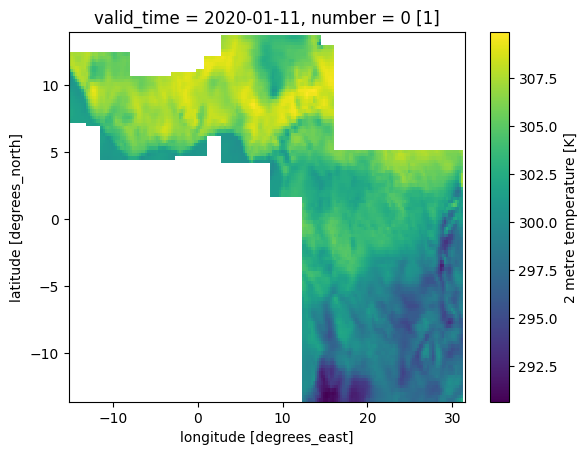

In [3]:
import xarray as xr
ds=xr.open_zarr(r"/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr")
ds.t2m.isel(valid_time=10).plot()

# Vulnerability Function for Cocoa Yield Loss

This section implements a vulnerability function that estimates the percentage yield loss for cocoa based on daily maximum temperature and monthly precipitation. The function is defined as follows:

\[
L(T, P) = 100 \times \left(1 - \exp\left[-\alpha \cdot \max(0, T - T_{\text{opt}})\right]\right) + \beta \cdot \max(0, P_{\text{th}} - P)
\]

where:
- \(T\) is the daily maximum temperature in degrees Celsius.
- \(T_{\text{opt}}\) is the optimum temperature for cocoa (assumed here as 24 °C).
- \(\alpha\) is the temperature sensitivity coefficient (default value 0.11).
- \(P\) is the monthly precipitation in mm.
- \(P_{\text{th}}\) is the critical precipitation threshold (assumed 100 mm).
- \(\beta\) is the precipitation deficit coefficient (default value 0.0075 per mm).

This function is inspired by quantitative approaches found in the literature, such as the studies by [Schroth et al., 2016](http://dx.doi.org/10.1016/j.scitotenv.2016.03.024) and [Läderach et al., 2013](http://dx.doi.org/10.1007/s10584-013-0774-8), which relate climate hazards (e.g., excessive temperature and rainfall deficits) to changes in the climatic suitability for cocoa. In our formulation, the yield loss increases exponentially when the temperature exceeds the optimum and linearly when precipitation falls below the threshold.

Below is the Python code that defines and demonstrates the usage of this vulnerability function.

In [4]:
import numpy as np

def vulnerability_loss(T, P, T_opt=24.0+273.15, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Compute the estimated yield loss percentage for cocoa based on daily maximum temperature (T)
    and monthly total precipitation (P). Temperature is expected in Kelvin.
    
    Parameters:
    - T (float): Daily maximum temperature in Kelvin.
    - P (float): Monthly total precipitation (mm).
    - T_opt (float): Optimum temperature for cocoa (default is 24°C in Kelvin, i.e., 297.15 K).
    - P_th (float): Critical precipitation threshold (default 100 mm).
    - alpha (float): Temperature sensitivity coefficient (default 0.11).
    - beta (float): Precipitation deficit coefficient (default 0.0075 per mm deficit).
    
    Returns:
    - float: Estimated yield loss percentage.
    
    The function is defined as:
    
    L(T, P) = 100 * (1 - exp[-alpha * max(0, T - T_opt)]) + beta * max(0, P_th - P)
    """
    temp_excess = max(0, T - T_opt)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    precip_deficit = max(0, P_th - P)
    precip_effect = beta * precip_deficit
    return temp_effect + precip_effect

# Example usage:
# Temperature example: 26°C converted to Kelvin (26 + 273.15 = 299.15 K)
T_example = 26 + 273.15  
# Monthly precipitation example: 80 mm (20 mm below the 100 mm threshold)
P_example = 80  
loss_percentage = vulnerability_loss(T_example, P_example)
print(f"Estimated yield loss percentage: {loss_percentage:.2f}%")

Estimated yield loss percentage: 19.90%


In [7]:

import xarray as xr
import numpy as np

# Assuming vulnerability_loss function is defined as in our previous code snippet.
def vulnerability_loss(T, P, T_opt=24.0+273.15, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Compute the estimated yield loss percentage for cocoa based on daily maximum temperature (in Kelvin)
    and monthly total precipitation (mm).
    """
    temp_excess = np.maximum(0, T - T_opt)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    precip_deficit = np.maximum(0, P_th - P)
    precip_effect = beta * precip_deficit
    return temp_effect + precip_effect

# Open the aggregated climate Zarr store
zarr_store = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr"
ds = xr.open_zarr(zarr_store)

# Check variable names (assume temperature is 't2m' and precipitation is 'tp')
print(ds)

# --- Temporal Aggregation if Needed ---
# If ds.t2m is daily and ds.tp is daily, but you need monthly precipitation:
# For example, group by month for precipitation:
ds_monthly_tp = ds.tp.resample(valid_time="1M").sum()  # monthly total precipitation
# For temperature, if you need the daily maximum, assume ds.t2m already is daily max,
# or resample if needed:
# ds_daily_t2m = ds.t2m.resample(valid_time="1D").max()

# --- Align Datasets ---
# We assume that the regridding already produced a common spatial grid.
# For temporal alignment, you may need to match the time coordinates.
# Here, we'll assume ds.t2m (daily) and ds_monthly_tp (monthly) need to be combined.
# One approach is to apply the vulnerability function on a per-month basis.

# Example: Compute vulnerability for each month.
# This snippet loops over each month, applying the function on the daily maximum temperature and the monthly precipitation total.
vulnerability_list = []
for month, t2m_month in ds.t2m.groupby("valid_time.month"):
    # Get the corresponding monthly precipitation value (broadcast to the daily t2m shape)
    # Here we assume one precipitation value per month per grid point.
    tp_month = ds_monthly_tp.sel(valid_time=ds_monthly_tp.valid_time.dt.month == month)
    
    # If tp_month has one time value per month, expand dims to match t2m_month along the time dimension.
    # Note: Adjust this step based on the actual shape of your data.
    tp_broadcast = tp_month.squeeze("valid_time")
    
    # Apply the function elementwise using apply_ufunc.
    # Here, vectorize=True makes the function apply elementwise.
    loss = xr.apply_ufunc(
        vulnerability_loss,
        t2m_month, tp_broadcast,
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    )
    # Assign the month coordinate for later concatenation
    loss = loss.assign_coords(valid_time=t2m_month.valid_time)
    vulnerability_list.append(loss)

# Combine the monthly results back along the time dimension
vulnerability_da = xr.concat(vulnerability_list, dim="valid_time")

# Add the vulnerability data array to the dataset
ds = ds.assign(vulnerability=vulnerability_da)

print(ds)

<xarray.Dataset> Size: 120MB
Dimensions:     (valid_time: 366, lat: 110, lon: 187)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
    number      int64 8B ...
  * lon         (lon) float64 1kB -15.08 -14.83 -14.58 ... 30.93 31.18 31.43
  * lat         (lat) float64 880B -13.46 -13.21 -12.96 ... 13.3 13.55 13.8
Data variables:
    tp          (valid_time, lat, lon) float64 60MB dask.array<chunksize=(92, 28, 47), meta=np.ndarray>
    t2m         (valid_time, lat, lon) float64 60MB dask.array<chunksize=(92, 28, 47), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
<xarray.Dataset> Size: 181MB
Dimensions:        (valid_time: 366, lat: 110, lon: 187)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 3kB 2

/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


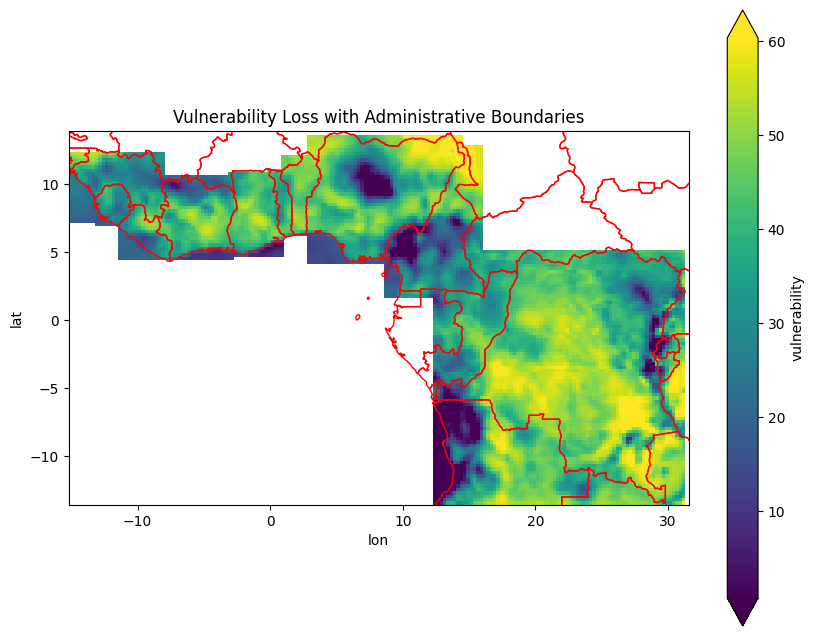

In [6]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# Open the aggregated dataset (assumed already loaded)
# ds = xr.open_zarr("/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr")

# Select a specific time slice (e.g., index 240)
vuln_slice = ds.vulnerability.isel(valid_time=240)

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the vulnerability field on the defined axis
vuln_slice.plot(ax=ax, cmap="viridis", robust=True)

# Read the shapefile (GeoJSON file in this case)
shapefile_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")

# Overlay the shapefile boundaries
gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=1)

ax.set_title("Vulnerability Loss with Administrative Boundaries")
plt.show()

In [11]:
ds_cocoa

<xarray.Dataset> Size: 415MB
Dimensions:   (lon: 7200, lat: 3600)
Coordinates:
  * lon       (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat       (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
Data variables:
    harvarea  (lat, lon) float32 104MB ...
    croparea  (lat, lon) float32 104MB ...
    qual      (lat, lon) float32 104MB ...
    set       (lat, lon) float32 104MB ...
Attributes:
    Creation date:  10-Mar-2024 09:38:30
    Authors:        F. Maggi, F.H.M. Tang, T.H. Nguyen
    Version:        v1.08

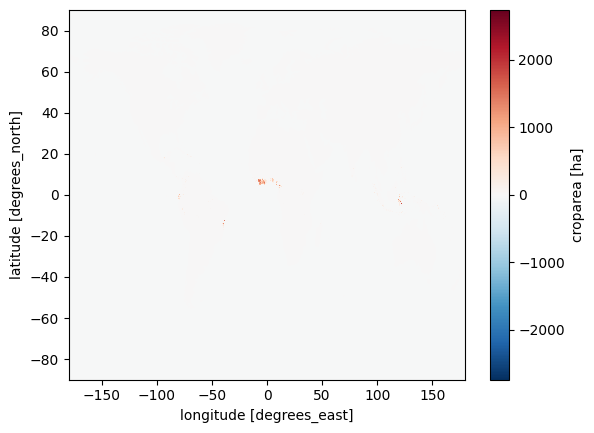

In [15]:
ds_cocoa.croparea.plot()
shapefile_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")

# Overlay the shapefile boundaries
gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=1)

ax.set_title("Vulnerability Loss with Administrative Boundaries")
plt.show()

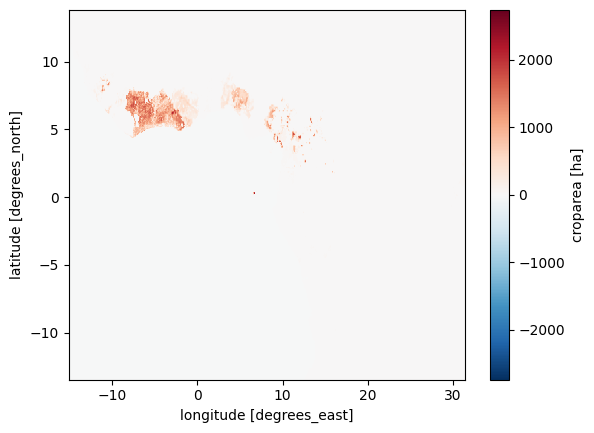

In [31]:
ds_coco_cliped=ds_cocoa.sel(lat=slice(ds['lat'].values.min(),ds['lat'].values.max())).sel(lon=slice(ds['lon'].values.min(),ds['lon'].values.max()))
ds_coco_cliped.croparea.plot()

In [21]:
ds

<xarray.Dataset> Size: 181MB
Dimensions:        (valid_time: 366, lat: 110, lon: 187)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
    number         int64 8B ...
  * lon            (lon) float64 1kB -15.08 -14.83 -14.58 ... 30.93 31.18 31.43
  * lat            (lat) float64 880B -13.46 -13.21 -12.96 ... 13.3 13.55 13.8
Data variables:
    tp             (valid_time, lat, lon) float64 60MB dask.array<chunksize=(92, 28, 47), meta=np.ndarray>
    t2m            (valid_time, lat, lon) float64 60MB dask.array<chunksize=(92, 28, 47), meta=np.ndarray>
    vulnerability  (valid_time, lat, lon) float64 60MB dask.array<chunksize=(31, 28, 47), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [1]:
import os

base_path = "/Users/charly_1/Documents/GitHub/crop_analysis/src/utilities/drought-comodities"

structure = {
    "00_utils": ["filters.py", "tests_stationarity.py", "plotting.py"],
    "01_data": ["download_commodity_prices.py", "process_spei.py", "data_description.md"],
    "02_modeling": ["spectral_factor_model.py", "ols_bootstrap.py", "arima_forecasting.py"],
    "03_results": ["run_beta_analysis.py", "run_forecasting.py"],
    "03_results/figures": [],  # directory only
}

# Main script and config
main_files = {
    "main.py": 'if __name__ == "__main__":\n    print("Run pipeline")\n',
    "config.yaml": '# Configuration for commodity replication\n'
}

# Create folders and files
for folder, files in structure.items():
    folder_path = os.path.join(base_path, folder)
    os.makedirs(folder_path, exist_ok=True)
    for file in files:
        file_path = os.path.join(folder_path, file)
        with open(file_path, "w") as f:
            if file.endswith(".py"):
                f.write('if __name__ == "__main__":\n    print("Running {}")\n'.format(file))
            elif file.endswith(".md"):
                f.write(f"# {file.replace('_', ' ').title().replace('.Md', '')}\n")

# Create main.py and config.yaml
for file, content in main_files.items():
    file_path = os.path.join(base_path, file)
    with open(file_path, "w") as f:
        f.write(content)

print("Project structure created successfully.")

Project structure created successfully.


In [6]:
ds

<xarray.Dataset> Size: 723MB
Dimensions:     (lat: 247, lon: 497, valid_time: 366)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * lon         (lon) float64 4kB -8.607 -8.557 -8.507 ... 16.09 16.14 16.19
  * lat         (lat) float64 2kB 1.654 1.704 1.754 1.804 ... 13.85 13.9 13.95
Data variables:
    qual        (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    croparea    (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    tp          (valid_time, lat, lon) float64 359MB dask.array<chunksize=(92, 247, 497), meta=np.ndarray>
    t2m         (valid_time, lat, lon) float64 359MB dask.array<chunksize=(92, 247, 497), meta=np.ndarray>
    harvarea    (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    set         (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    Creation date:           10-Mar-2024 09:38:30
    Authors:                 F. Maggi, F.H.M. Tang, T.H. Nguyen
    Version:                 v1.08

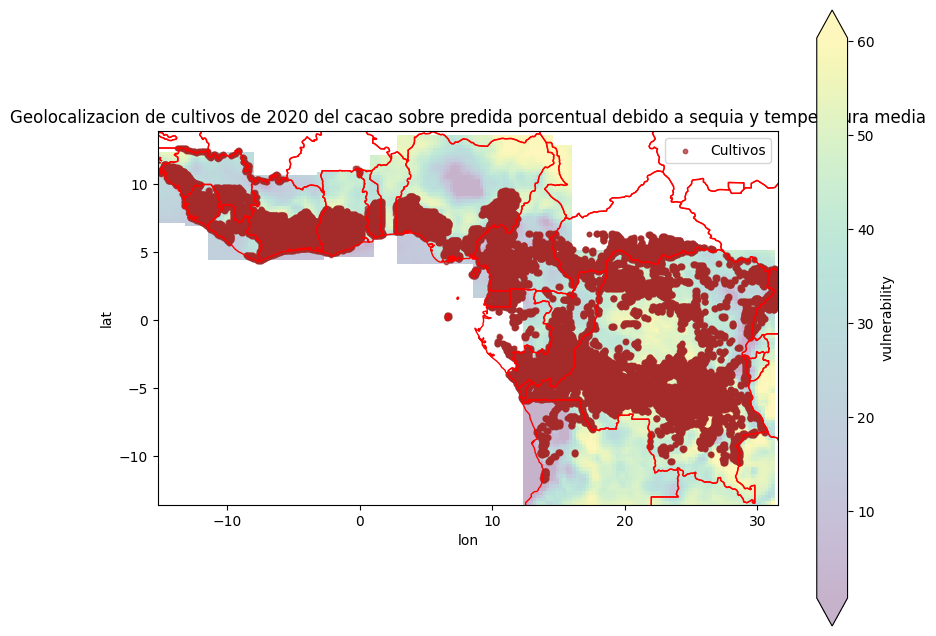

In [10]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


# Se asume que 'ds' ya está cargado
vuln_slice = ds.vulnerability.isel(valid_time=240)
ds_cocoa = xr.open_dataset(r"/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_cocoa.nc")
ds_coco_cliped = ds_cocoa.sel(
    lat=slice(ds["lat"].values.min(), ds["lat"].values.max())
).sel(
    lon=slice(ds["lon"].values.min(), ds["lon"].values.max())
)
# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Mostrar el campo de vulnerabilidad como fondo
vuln_slice.plot(ax=ax, cmap="viridis", robust=True, alpha=0.3)

# Crear máscara para los puntos donde hay cultivo (por ejemplo, croparea > 0)
mask = ds_coco_cliped.croparea > 0

# Obtener las coordenadas 1D
lats_1d = ds_coco_cliped["lat"].values
lons_1d = ds_coco_cliped["lon"].values

# Crear mallas de coordenadas a partir de las coordenadas 1D
lon_grid, lat_grid = np.meshgrid(lons_1d, lats_1d)

# Aplicar la máscara para extraer solo los puntos con cultivo
lats = lat_grid[mask.values]
lons = lon_grid[mask.values]

# Graficar los puntos de cultivo
ax.scatter(lons, lats, color="brown", s=10, alpha=0.7, label="Cultivos")

# Leer el shapefile (GeoJSON) y reproyectarlo a EPSG:4326
shapefile_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")

# Superponer las fronteras administrativas
gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=1)

# Añadir título y leyenda
ax.set_title("Geolocalizacion de cultivos de 2020 del cacao sobre predida porcentual debido a sequia y temperatura media")
ax.legend()

plt.show()

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# Open the aggregated dataset (assumed already loaded)
# ds = xr.open_zarr("/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr")

# Select a specific time slice (e.g., index 240)
vuln_slice = ds.vulnerability.isel(valid_time=240)
ds_cocoa=xr.open_dataset(r'/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_cocoa.nc')
# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the vulnerability field on the defined axis
vuln_slice.plot(ax=ax, cmap="viridis", robust=True)
ds_cocoa.croparea.plot.scatter(ax=ax)
# Read the shapefile (GeoJSON file in this case)
shapefile_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")

# Overlay the shapefile boundaries
gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=1)

ax.set_title("Vulnerability Loss with Administrative Boundaries")
plt.show()

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# Open the aggregated dataset (assumed already loaded)
# ds = xr.open_zarr("/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr")

# Select a specific time slice (e.g., index 240)
vuln_slice = ds.vulnerability.isel(valid_time=240)

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the vulnerability field on the defined axis
vuln_slice.plot(ax=ax, cmap="viridis", robust=True)

# Read the shapefile (GeoJSON file in this case)
shapefile_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")

# Overlay the shapefile boundaries
gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=1)

ax.set_title("Vulnerability Loss with Administrative Boundaries")
plt.show()

In [14]:
import os
import xarray as xr
import numpy as np
import shutil

# Paths
cocoa_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_cocoa.nc"
climate_zarr = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr"
merged_zarr = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_merged_data.zarr"

# Open the cocoa (crop) dataset and print its structure
cocoa_ds = xr.open_dataset(cocoa_path)
print("Cocoa dataset structure:")
print(cocoa_ds)

# Compute the crop data resolution from the cocoa dataset (assumes coordinates 'lat' and 'lon')
# (If not already sorted, you can sort them; here we assume they are monotonic.)
crop_lat = cocoa_ds.lat
crop_lon = cocoa_ds.lon
crop_lat_res = (crop_lat.max() - crop_lat.min()) / (len(crop_lat) - 1)
crop_lon_res = (crop_lon.max() - crop_lon.min()) / (len(crop_lon) - 1)
print(f"Crop resolution: lat_res = {crop_lat_res.values}, lon_res = {crop_lon_res.values}")

# Open the aggregated climate dataset (which has been merged from individual country files)
climate_ds = xr.open_zarr(climate_zarr)
print("Climate dataset structure:")
print(climate_ds)

# Extract the geographical extent from the climate hazard data
climate_lat_min = climate_ds.lat.min().item()
climate_lat_max = climate_ds.lat.max().item()
climate_lon_min = climate_ds.lon.min().item()
climate_lon_max = climate_ds.lon.max().item()
print(f"Climate extent: lat [{climate_lat_min}, {climate_lat_max}], lon [{climate_lon_min}, {climate_lon_max}]")

# Create a new grid: use the climate extent but with the crop data's resolution
lat_new = np.arange(climate_lat_min, climate_lat_max + crop_lat_res, crop_lat_res)
lon_new = np.arange(climate_lon_min, climate_lon_max + crop_lon_res, crop_lon_res)
print(f"Common grid: {len(lat_new)} lat points, {len(lon_new)} lon points.")

# Regrid the climate dataset to the new grid using interpolation
climate_regrid = climate_ds.interp(lat=lat_new, lon=lon_new)

# Regrid the cocoa dataset to the same new grid.
# Additionally, subset the cocoa dataset to the climate extent.
cocoa_regrid = cocoa_ds.interp(lat=lat_new, lon=lon_new)

# Now merge the two datasets.
# Using xr.merge ensures that variables from both datasets are kept.
# In regions where one dataset has NaN, the other’s valid values are preserved.
merged_ds = xr.merge([climate_regrid, cocoa_regrid], combine_attrs="drop_conflicts")

print("Merged dataset structure:")
print(merged_ds)

# Optionally, write the merged dataset to a new Zarr store
if os.path.exists(merged_zarr):
    shutil.rmtree(merged_zarr)

merged_ds.to_zarr(merged_zarr, mode="w")
print(f"Merged dataset saved to Zarr store at: {merged_zarr}")

Cocoa dataset structure:
<xarray.Dataset> Size: 415MB
Dimensions:   (lon: 7200, lat: 3600)
Coordinates:
  * lon       (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat       (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
Data variables:
    harvarea  (lat, lon) float32 104MB ...
    croparea  (lat, lon) float32 104MB ...
    qual      (lat, lon) float32 104MB ...
    set       (lat, lon) float32 104MB ...
Attributes:
    Creation date:  10-Mar-2024 09:38:30
    Authors:        F. Maggi, F.H.M. Tang, T.H. Nguyen
    Version:        v1.08
Crop resolution: lat_res = 0.05000000074505806, lon_res = 0.05000000074505806
Climate dataset structure:
<xarray.Dataset> Size: 29MB
Dimensions:     (valid_time: 366, lat: 50, lon: 100)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
    number      int64 8B ...
  * lon         (lon) float64 800B -8.607 -8.357 -8.107 ... 15.65 15.9 16.15
  * lat         (lat) float64 400B 1.654 1.

/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Merged dataset saved to Zarr store at: /Users/charly_1/Documents/GitHub/crop_analysis/aggregated_merged_data.zarr


In [3]:

import xarray as xr
import numpy as np

# Assuming vulnerability_loss function is defined as in our previous code snippet.
def vulnerability_loss(T, P, T_opt=24.0+273.15, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Compute the estimated yield loss percentage for cocoa based on daily maximum temperature (in Kelvin)
    and monthly total precipitation (mm).
    """
    temp_excess = np.maximum(0, T - T_opt)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    precip_deficit = np.maximum(0, P_th - P)
    precip_effect = beta * precip_deficit
    return temp_effect + precip_effect
import numpy as np

def daily_vulnerability_loss(T, P, T_opt=24.0+273.15, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Calcula el daño diario estimado (%) en el rendimiento del cacao basado en la temperatura máxima diaria (T)
    y la precipitación diaria (P). La función asume que el daño por precipitación se reparte de manera uniforme 
    durante un mes (30 días).
    
    Parámetros:
    - T (float): Temperatura máxima diaria en Kelvin.
    - P (float): Precipitación diaria (mm).
    - T_opt (float): Temperatura óptima para el cacao (por defecto 24°C en Kelvin, es decir, 297.15 K).
    - P_th (float): Umbral de precipitación mensual crítica (por defecto 100 mm). 
                     Se asume que el umbral diario es P_th/30.
    - alpha (float): Coeficiente de sensibilidad a la temperatura (por defecto 0.11).
    - beta (float): Coeficiente por déficit de precipitación (por defecto 0.0075 mm⁻¹).
    
    Retorna:
    - float: Porcentaje estimado de pérdida en rendimiento para ese día.
    
    La función se define de la siguiente forma, ajustada a datos diarios:
    
    L_diaria(T, P) = [100 * (1 - exp(-alpha * max(0, T - T_opt))) 
                      + beta * max(0, (P_th/30 - P))] / 30
                      
    Nota: Este ajuste es una aproximación y puede requerir calibración adicional con datos de campo.
    """
    # Umbral diario de precipitación
    daily_P_th = P_th / 30.0
    # Exceso de temperatura
    temp_excess = max(0, T - T_opt)
    # Efecto de la temperatura (ya en porcentaje)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    # Deficiencia de precipitación en el día
    precip_deficit = max(0, daily_P_th - P)
    precip_effect = beta * precip_deficit
    # Dividimos el resultado por 30 para distribuir el daño en el día
    daily_loss = (temp_effect + precip_effect) / 30.0
    return daily_loss

# Open the aggregated climate Zarr store
zarr_store = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_merged_data.zarr"
ds = xr.open_zarr(zarr_store)

# Check variable names (assume temperature is 't2m' and precipitation is 'tp')
print(ds)

# --- Temporal Aggregation if Needed ---
# If ds.t2m is daily and ds.tp is daily, but you need monthly precipitation:
# For example, group by month for precipitation:
ds_monthly_tp = ds.tp.resample(valid_time="1M").sum()  # monthly total precipitation
# For temperature, if you need the daily maximum, assume ds.t2m already is daily max,
# or resample if needed:
# ds_daily_t2m = ds.t2m.resample(valid_time="1D").max()

# --- Align Datasets ---
# We assume that the regridding already produced a common spatial grid.
# For temporal alignment, you may need to match the time coordinates.
# Here, we'll assume ds.t2m (daily) and ds_monthly_tp (monthly) need to be combined.
# One approach is to apply the vulnerability function on a per-month basis.

# Example: Compute vulnerability for each month.
# This snippet loops over each month, applying the function on the daily maximum temperature and the monthly precipitation total.
vulnerability_list = []
for month, t2m_month in ds.t2m.groupby("valid_time.month"):
    # Get the corresponding monthly precipitation value (broadcast to the daily t2m shape)
    # Here we assume one precipitation value per month per grid point.
    tp_month = ds_monthly_tp.sel(valid_time=ds_monthly_tp.valid_time.dt.month == month)
    
    # If tp_month has one time value per month, expand dims to match t2m_month along the time dimension.
    # Note: Adjust this step based on the actual shape of your data.
    tp_broadcast = tp_month.squeeze("valid_time")
    
    # Apply the function elementwise using apply_ufunc.
    # Here, vectorize=True makes the function apply elementwise.
    loss = xr.apply_ufunc(
        daily_vulnerability_loss,
        t2m_month, tp_broadcast,
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    )
    # Assign the month coordinate for later concatenation
    loss = loss.assign_coords(valid_time=t2m_month.valid_time)
    vulnerability_list.append(loss)

# Combine the monthly results back along the time dimension
vulnerability_da = xr.concat(vulnerability_list, dim="valid_time")

# Add the vulnerability data array to the dataset
ds = ds.assign(vulnerability=vulnerability_da)

print(ds)

<xarray.Dataset> Size: 723MB
Dimensions:     (lat: 247, lon: 497, valid_time: 366)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * lon         (lon) float64 4kB -8.607 -8.557 -8.507 ... 16.09 16.14 16.19
  * lat         (lat) float64 2kB 1.654 1.704 1.754 1.804 ... 13.85 13.9 13.95
Data variables:
    qual        (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    croparea    (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    tp          (valid_time, lat, lon) float64 359MB dask.array<chunksize=(92, 247, 497), meta=np.ndarray>
    t2m         (valid_time, lat, lon) float64 359MB dask.array<chunksize=(92, 247, 497), meta=np.ndarray>
    harvarea    (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    set         (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    G

/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [4]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:        (lat: 247, lon: 497, valid_time: 366)
Coordinates:
    number         int64 8B ...
  * valid_time     (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * lon            (lon) float64 4kB -8.607 -8.557 -8.507 ... 16.09 16.14 16.19
  * lat            (lat) float64 2kB 1.654 1.704 1.754 ... 13.85 13.9 13.95
Data variables:
    qual           (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    croparea       (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    tp             (valid_time, lat, lon) float64 359MB dask.array<chunksize=(92, 247, 497), meta=np.ndarray>
    t2m            (valid_time, lat, lon) float64 359MB dask.array<chunksize=(92, 247, 497), meta=np.ndarray>
    harvarea       (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    set            (lat, lon) float64 982kB dask.array<chunksize=(124, 249), meta=np.ndarray>
    vulnerability  (valid_time, lat, lon) float64 359MB dask.array<chunksize=(31, 247, 497), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    Creation date:           10-Mar-2024 09:38:30
    Authors:                 F. Maggi, F.H.M. Tang, T.H. Nguyen
    Version:                 v1.08

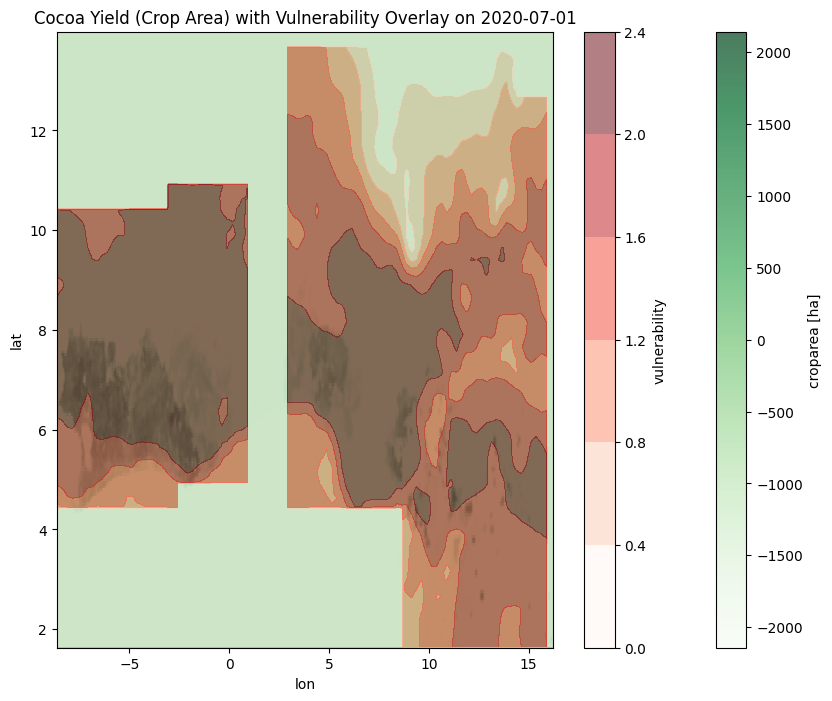

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

# Open the merged dataset (assuming it contains both cocoa yield and vulnerability)

# Select a day for the vulnerability field; 
# Here we either use a date (if valid_time is datetime) or an index.
# For example, saelecting the vulnerability for July 1, 2020:
vuln_slice = ds['vulnerability'].isel(valid_time=0)

# Alternatively, use isel if you prefer an index, e.g.,
# vuln_slice = ds.vulnerability.isel(valid_time=240)

# Select the cocoa yield field; here we assume 'croparea' represents the cocoa yield data.
cocoa_field = ds.croparea

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the cocoa yield as the base layer (you can choose a colormap appropriate for your data)
cocoa_field.plot(ax=ax, cmap="Greens", add_colorbar=True, alpha=0.7)

# Overlay the vulnerability field using a contour or pcolormesh plot.
# Here, we use contourf with some transparency.
vuln_slice.plot.contourf(ax=ax, cmap="Reds", alpha=0.5, add_colorbar=True)

ax.set_title("Cocoa Yield (Crop Area) with Vulnerability Overlay on 2020-07-01")
plt.show()

## 3. Data Preprocessing and Aggregation
Convert the date columns to datetime (if not already done), handle missing values and outliers, aggregate daily data into monthly metrics (e.g., averages, sums, or counts of extreme events), and merge both datasets using the `date` column.

In [ ]:
# Example: Aggregating daily climate data to monthly data
climate_monthly = climate_df.resample('M', on='date').agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    # Assuming 'hail' is a binary indicator, count the number of days with hail events
    'hail': 'sum'
}).reset_index()

# Merge climate and price data
data = pd.merge(price_df, climate_monthly, on='date', how='inner')

## 4. Exploratory Data Analysis (EDA)
Visualize the time series, examine variable distributions, and compute a correlation matrix to identify preliminary relationships.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price'], label='CFD Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('CFD Price Over Time')
plt.legend()
plt.show()

# Calculate and print the correlation matrix
corr_matrix = data.corr()
print(corr_matrix)

## 5. Feature Engineering
Create new features such as drought indices, counts of extreme events, or lag variables. For example, create a one-month lag for precipitation.

In [ ]:
data['precipitation_lag1'] = data['precipitation'].shift(1)
# Remove rows with NA values resulting from the shift
data = data.dropna()

## 6. Modeling: Training a Simple Machine Learning Model
Use a simple model (e.g., RandomForest) to predict the CFD price using the climate variables as predictors.

In [ ]:
# Define features and target
features = ['temperature', 'precipitation', 'hail', 'precipitation_lag1']
target = 'price'

# Use TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

## 7. Model Evaluation and Interpretation
Visualize the predictions versus the actual values and analyze feature importance to understand the impact of each climate variable.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual Price')
plt.plot(test_data['date'], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted CFD Prices')
plt.legend()
plt.show()

# Display feature importances
importances = model.feature_importances_
for feat, imp in zip(features, importances):
    print(f'{feat}: {imp:.2f}')

## 8. Conclusion and Next Steps
Summarize your findings and the model's predictive capability. Discuss limitations and potential improvements (e.g., incorporating more climatic variables, using hybrid models or LSTM networks). Outline the next steps to transition this PoC into a production-level model, such as integrating streaming data and continuously updating the model.

# End of Notebook

This PoC serves as a starting point to evaluate whether incorporating climate data can improve the prediction of agricultural CFD prices. Further research and model refinement will be necessary to address challenges such as data granularity, external economic factors, and model adaptability over time.